In [ ]:
import numpy as np
import torch
import rc_tools as rct
import rc_analysis as rca
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import fsolve
from scipy.signal import argrelextrema
import sys
import warnings
import time

import pdb

from skopt.space import Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")

from jupyterthemes import jtplot
jtplot.style()

np.random.seed(11)
torch.set_printoptions(precision=10)
dtype = torch.float32 

print(f'Python: {sys.version}')
print(f'Numpy: {np.__version__}')
print(f'Torch: {torch.__version__}')

FREERUN = 20
DT = .02

rho = 28.0
sigma = 10.0
beta = 8/3

def f(state, t):
    x,y,z = state
    return sigma*(y-x), x*(rho-z)-y, x*y - beta*z

state0 = [1.,1.,1.]
t = np.arange(0,300+FREERUN,DT)
states = odeint(f,state0,t)

muX = np.mean(states[:,0])
signal = states[:,0]-muX
M = signal.shape[0] - int(FREERUN/DT)
K = 1
L = 1
RF = .5
TEST = 1000
LEAD = 100
BURNIN = 100
REG = 1e-8
TRAINLENGTH = M-TEST


MINMAX = np.max(signal[:TRAINLENGTH+TEST]) - np.min(signal[:TRAINLENGTH+TEST])
BINS = 50

print(f'Signal length M={M}')

In [3]:
def get_weight_matricesGPU(k,n,l,ri,ro):
    win = torch.rand((n,k),dtype=dtype,
                      device=torch.device('cuda')).sub(.5).mul(ri)
    wfb = torch.zeros((n,l),dtype=dtype, device=torch.device('cuda'))
    wout = torch.rand((l,n+k),dtype=dtype,
                      device=torch.device('cuda')).sub(.5).mul(ro)
    return win, wfb, wout

def set_vectorsGPU(n,l,r):
    x0 = torch.rand((n,1),dtype=dtype,
                      device=torch.device('cuda')).sub(.5).mul(r)
    y0 = torch.zeros((l,1),dtype=dtype, device=torch.device('cuda'))
    return x0, y0

def update_res_stateGPU(wnet,xt,uxy,a,g):
    z = torch.matmul(wnet,uxy)
    return torch.mul(xt,1-a) + torch.mul(torch.tanh(z),a*g)

def predict_yGPU(wout,xu):
    return torch.matmul(wout, xu)

def get_matrixGPU(n,r,sr):
    A = (torch.rand((n,n),dtype=dtype,
                   device=torch.device('cuda'))-.5)*r
    At = torch.transpose(A,0,1)
    D = torch.diag(torch.diag(A))   
    W = A + At - D
    eig = torch.eig(W, eigenvectors=False)
    wsr = torch.max(torch.abs(eig[0]))
    return W.div(wsr).mul(sr)

def cosFactor(av,bv):
    f = 0
    cosSIM = 1.0
    try:
        currentCOS = np.dot(av, bv)/(np.linalg.norm(av)*np.linalg.norm(bv))
    except: # catch *all* exceptions
        f = sys.exc_info()[0]
        print(f)
        currentCOS = [0.0] # If error default orthogonal
        
    
    if(not f):
        if(np.any(np.isnan(currentCOS))): # If NaN default to orthogonal
            currentCOS = [0.0]
        cosSIM = 1 - currentCOS[0]
    else:
        print('Error f')
    return cosSIM

def resize_spaces(mn, mx, best, isAlpha=False):
    #pdb.set_trace()
    if(best.size==0):
        new_mn = np.max([0, mn - .5*mn])
        new_mx = 1.5*mx
    else:
        best_mn = np.min(best)
        best_mx = np.max(best)
        mn_bound = (best_mn-mn)/2
        mx_bound = (mx -best_mx)/2
        new_mn, new_mx = best_mn-mn_bound, best_mx+mx_bound
        print(f'\nBest mn:{best_mn:.3f}\t mn:{best_mx:.3f}')
        print(f'New bounds mn--mx: {mn_bound:.3f}--{mx_bound:.3f}')
    if(isAlpha):
        if(new_mx>1):
            new_mx = 1
    
    return new_mn, new_mx

M=15000


In [13]:
#space = [Real(.3,.4, name='a'),
#         Real(1.,1.4, name='sr'),
#         Real(.8,1.1, name='amp'),
#         Real(.001,3., name='ri'),
#         Real(2.,5., name='rr')
#        ]
#space = [Real(.001, 1, name='a'),
#         Real(.001, 8., name='sr'),
#         Real(.001, 1, name='amp'), 
#         Real(.001, 1., name='ri'),
#         Real(.001, 5., name='rr')
#        ]
min_a, max_a = .001, 1.
min_sr, max_sr = .001, 8.
min_g, max_g = .001, 1.
min_ri, max_ri = .001, 1.
min_rr, max_rr = .001, 5.
space = [Real(min_a, max_a, name='a'),
                 Real(min_sr, max_sr, name='sr'),
                 Real(min_g, max_g, name='amp'), 
                 Real(min_ri, max_ri, name='ri'),
                 Real(min_rr, max_rr, name='rr')
                ]

@use_named_args(space)
def loop(a=1.0,sr=1.0,amp=1.0,ri=1.0,rr=1.0):
    start = time.time()
    global running_error, s, counter, signal, N, \
           alphas, rhos, gammas, inScales, resScales
    
    ut = torch.zeros((1,1),dtype=dtype, device=torch.device('cuda'))
    tp = torch.zeros((1,1),dtype=dtype, device=torch.device('cuda'))
    
    Wres = get_matrixGPU(N,rr,sr)
    Win, Wfb, Wout = get_weight_matricesGPU(K,N,L,ri,RF)
    Wnet = torch.cat((Win,Wres,Wfb),1)
    xt, yt = set_vectorsGPU(N,L,rr)

    states = torch.zeros((TRAINLENGTH, N+K),dtype=dtype, device='cuda:0')
    targets = torch.zeros((TRAINLENGTH),dtype=dtype, device='cuda:0')
    for i in range(TRAINLENGTH):
        ut[0,0] = s[i]
        tp[0,0] = s[i+1]
        targets[i] = s[i+1]
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.transpose(torch.cat((xt1,ut),0),0,1)
        states[i,:] = xu[0,:]
        xt, yt = xt1, tp 

    state = states.detach().cpu().numpy()
    #target = targets.detach().cpu().numpy()
    torch.cuda.synchronize()
    wout = rct.get_trained_weights(state[BURNIN:],
                                   signal[BURNIN+1:TRAINLENGTH+1],
                                   REG)
    Wout = torch.from_numpy(wout.reshape(L,N+K)).type(dtype).cuda()
    torch.cuda.synchronize()

    predictions = torch.zeros((M+int(FREERUN/DT),1),
                              dtype=dtype,
                              device=torch.device('cuda'))

    xt, yt = set_vectorsGPU(N,L,rr)
    ut.fill_(0.0)
    for i in range(M+int(FREERUN/DT)):
        if(i < TRAINLENGTH):
            ut[0,0] = s[i]
        else:
            ut = yt
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.cat((xt1,ut),0)
        yt1 = predict_yGPU(Wout,xu)
        predictions[i] = yt1[0,0]
        xt, yt = xt1, yt1

    yHat_GPU = predictions.detach().cpu().numpy()
    
    nrmse = 1000.0
    try:
        nrmse = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH+TEST],
                          yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST],
                          MINMAX) 
    except:
        pass
    
    
    av = signal[TRAINLENGTH:TRAINLENGTH+TEST].reshape(TEST,1)
    bv = np.squeeze(yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST]).reshape(TEST,1)
    num = np.squeeze(np.dot(av.T,bv))
    den = np.linalg.norm(av)*np.linalg.norm(bv)
    cosine_similarity = num/den
    cosine_distance = 1 - cosine_similarity
    dist = cosine_distance
    
    loss = nrmse + dist
    if(np.isnan(loss) or (np.isinf(loss) or (loss > 1000.0))):
        loss = 1000
    
    if((loss < running_error) & (loss < .9)):
        alphas.append(a)
        rhos.append(sr)
        gammas.append(amp)
        inScales.append(ri)
        resScales.append(rr)
        running_error = loss
        wnet = Wnet.detach().cpu().numpy()
        currentParams = np.array([a,sr,amp,ri,rr,loss])
        
        fig = plt.figure(figsize=(10,8))
        ax1 = plt.subplot(111)
        ax1.plot(signal[TRAINLENGTH-LEAD:], label='Target')
        ax1.plot(yHat_GPU[TRAINLENGTH-LEAD:], label='GPU')
        ax1.axvline(LEAD,c='orange',linestyle='dashed')
        ax1.axvline(LEAD+TEST,c='r',linestyle='dashed')
        ax1.legend()
        plt.show()
        fig.savefig(f'./X_Saved_Models/X_sz{N}_ref{ref}_run{rn}_iter{counter}.pdf',
                    format='pdf', bbox_inches='tight', pad_inches=.01)
        plt.close()
        
        np.save(f'./X_Saved_Models/X_it{counter}_{N}_Wnet',wnet)
        np.save(f'./X_Saved_Models/X_it{counter}_{N}_Preds',yHat_GPU)
        np.save(f'./X_Saved_Models/X_it{counter}_{N}_InstanceParams',currentParams)
        print(f' Iter={counter} a={a:.3f} sr={sr:.3f} amp={amp:.3f}',
              f' ri={ri:.3f} rr={rr:.3f} loss={loss:3f}\n\n')
    ####### Running info ##############################
    print(f'Iter: {counter} #### Diagnostic {loss:3f}   Time {(time.time()-start):.2f}',
          f' Best {running_error:.3f} NRMSE {nrmse:.3f} CD {dist:.3f}')
    ###### Store this run #############################
    counter += 1
    return loss

********** 1000 ***********
MSE 1000.000   CM 0.249
Loss 1000   lc 248.74713010905492


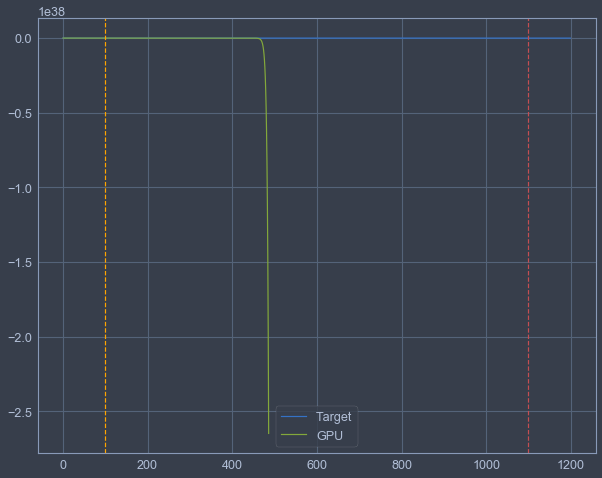

New Best Info a=0.069
 sr=5.318
 amp=0.195
 ri=0.926
 rr=0.527
 nrmse=1000.000
 KL 2.254


Iter: 0 #### Diagnostic 1000.000   Time 4.597 Best 248.747  KL 2.254 NRMSE 1000.000
MSE 1000.000   CM 1000.000
Iter: 1 #### Diagnostic 1000.000   Time 4.718 Best 248.747  KL 1000.000 NRMSE 1000.000
MSE 0.249   CM 0.136
Loss 0.24860725074865314   lc 0.033858844287628066


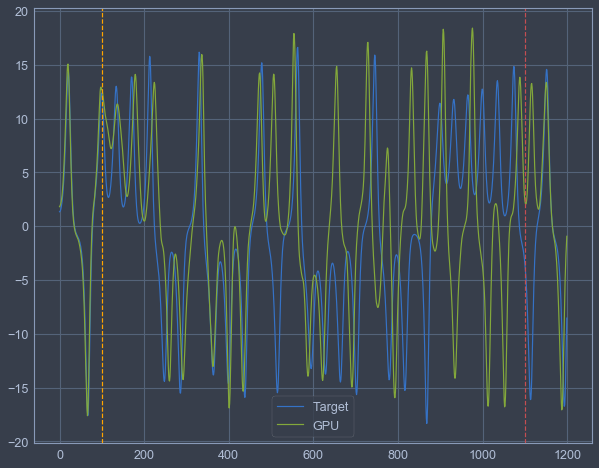

New Best Info a=0.714
 sr=4.144
 amp=0.786
 ri=0.588
 rr=3.684
 nrmse=0.249
 KL 1.037


Iter: 2 #### Diagnostic 0.249   Time 4.389 Best 0.034  KL 1.037 NRMSE 0.249
MSE 0.310   CM 0.035
Loss 0.3096059922040889   lc 0.01086372230136988


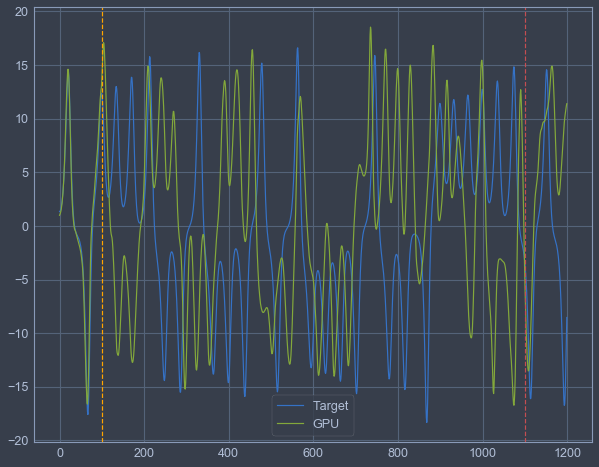

New Best Info a=0.673
 sr=7.761
 amp=0.989
 ri=0.778
 rr=0.127
 nrmse=0.310
 KL 0.097


Iter: 3 #### Diagnostic 0.310   Time 4.705 Best 0.011  KL 0.097 NRMSE 0.310
MSE 1000.000   CM 0.296
Iter: 4 #### Diagnostic 1000.000   Time 4.515 Best 0.011  KL 2.634 NRMSE 1000.000
MSE 0.333   CM 0.800
Iter: 5 #### Diagnostic 0.333   Time 3.917 Best 0.011  KL 13.792 NRMSE 0.333
MSE 1000.000   CM 0.169
Iter: 6 #### Diagnostic 1000.000   Time 4.445 Best 0.011  KL 0.415 NRMSE 1000.000
MSE 0.287   CM 0.872
Iter: 7 #### Diagnostic 0.287   Time 4.000 Best 0.011  KL 25.787 NRMSE 0.287
MSE 1000.000   CM 0.165
Iter: 8 #### Diagnostic 1000.000   Time 4.486 Best 0.011  KL 0.643 NRMSE 1000.000
MSE 0.276   CM 0.084
Iter: 9 #### Diagnostic 0.276   Time 4.855 Best 0.011  KL 0.610 NRMSE 0.276
MSE 1000.000   CM 0.282
Iter: 10 #### Diagnostic 1000.000   Time 4.743 Best 0.011  KL 2.970 NRMSE 1000.000
MSE 0.262   CM 0.026
Loss 0.26151547258925134   lc 0.006825829119609417


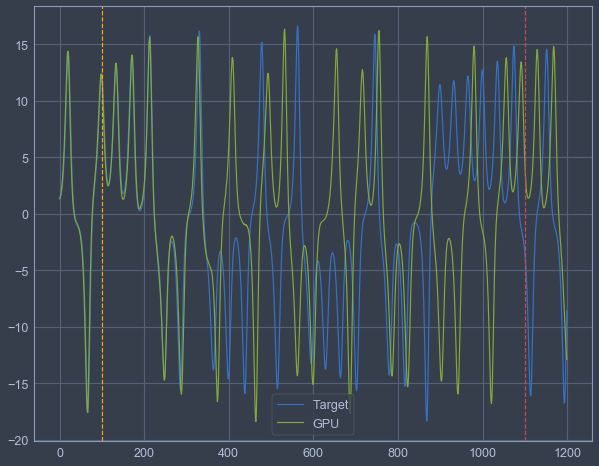

New Best Info a=0.994
 sr=2.562
 amp=0.789
 ri=0.216
 rr=4.756
 nrmse=0.262
 KL 0.069


Iter: 11 #### Diagnostic 0.262   Time 4.619 Best 0.007  KL 0.069 NRMSE 0.262
MSE 0.286   CM 0.069
Iter: 12 #### Diagnostic 0.286   Time 4.179 Best 0.007  KL 0.599 NRMSE 0.286
MSE 0.276   CM 0.135
Iter: 13 #### Diagnostic 0.276   Time 4.340 Best 0.007  KL 1.823 NRMSE 0.276
MSE 0.284   CM 0.163
Iter: 14 #### Diagnostic 0.284   Time 4.321 Best 0.007  KL 3.169 NRMSE 0.284
MSE 1000.000   CM 0.280
Iter: 15 #### Diagnostic 1000.000   Time 4.382 Best 0.007  KL 2.239 NRMSE 1000.000
MSE 1000.000   CM 0.152
Iter: 16 #### Diagnostic 1000.000   Time 4.692 Best 0.007  KL 1.777 NRMSE 1000.000
MSE 8.356   CM 0.607
Iter: 17 #### Diagnostic 8.356   Time 4.596 Best 0.007  KL 9.032 NRMSE 8.356
MSE 1000.000   CM 0.272
Iter: 18 #### Diagnostic 1000.000   Time 4.693 Best 0.007  KL 2.269 NRMSE 1000.000
MSE 1000.000   CM 0.079
Iter: 19 #### Diagnostic 1000.000   Time 4.283 Best 0.007  KL 0.860 NRMSE 1000.000
MSE 0.330   CM 

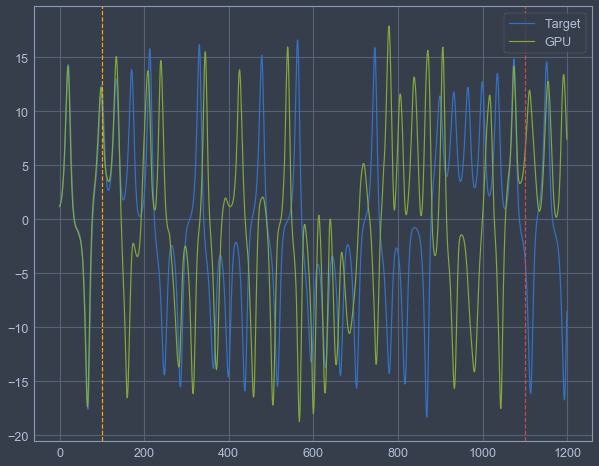

New Best Info a=0.873
 sr=6.353
 amp=0.648
 ri=0.490
 rr=1.246
 nrmse=0.298
 KL 0.088


Iter: 34 #### Diagnostic 0.298   Time 5.428 Best 0.006  KL 0.088 NRMSE 0.298
MSE 1000.000   CM 0.121
Iter: 35 #### Diagnostic 1000.000   Time 9.603 Best 0.006  KL 0.526 NRMSE 1000.000
MSE 1000.000   CM 0.297
Iter: 36 #### Diagnostic 1000.000   Time 7.014 Best 0.006  KL 2.453 NRMSE 1000.000
MSE 1000.000   CM 0.056
Iter: 37 #### Diagnostic 1000.000   Time 7.434 Best 0.006  KL 0.410 NRMSE 1000.000
MSE 1000.000   CM 0.204
Iter: 38 #### Diagnostic 1000.000   Time 6.363 Best 0.006  KL 2.542 NRMSE 1000.000
MSE 1000.000   CM 0.112
Iter: 39 #### Diagnostic 1000.000   Time 6.544 Best 0.006  KL 0.819 NRMSE 1000.000
MSE 1000.000   CM 0.222
Iter: 40 #### Diagnostic 1000.000   Time 7.042 Best 0.006  KL 1.128 NRMSE 1000.000
MSE 1000.000   CM 0.193
Iter: 41 #### Diagnostic 1000.000   Time 6.015 Best 0.006  KL 1.371 NRMSE 1000.000
MSE 0.286   CM 0.052
Iter: 42 #### Diagnostic 0.286   Time 7.975 Best 0.006  KL 0.632 

MSE 1000.000   CM 1000.000
Iter: 112 #### Diagnostic 1000.000   Time 5.135 Best 0.006  KL 1000.000 NRMSE 1000.000
MSE 0.215   CM 0.205
Iter: 113 #### Diagnostic 0.215   Time 4.026 Best 0.006  KL 1.516 NRMSE 0.215
MSE 0.275   CM 0.049
Iter: 114 #### Diagnostic 0.275   Time 4.037 Best 0.006  KL 0.321 NRMSE 0.275
MSE 0.295   CM 0.809
Iter: 115 #### Diagnostic 0.295   Time 8.336 Best 0.006  KL 12.086 NRMSE 0.295
MSE 0.274   CM 0.392
Iter: 116 #### Diagnostic 0.274   Time 5.082 Best 0.006  KL 6.656 NRMSE 0.274
MSE 0.312   CM 0.120
Iter: 117 #### Diagnostic 0.312   Time 5.313 Best 0.006  KL 0.540 NRMSE 0.312
MSE 0.321   CM 0.501
Iter: 118 #### Diagnostic 0.321   Time 5.159 Best 0.006  KL 7.222 NRMSE 0.321
MSE 0.333   CM 0.086
Iter: 119 #### Diagnostic 0.333   Time 5.412 Best 0.006  KL 0.474 NRMSE 0.333
MSE 0.332   CM 0.169
Iter: 120 #### Diagnostic 0.332   Time 5.279 Best 0.006  KL 1.509 NRMSE 0.332
MSE 0.330   CM 0.286
Iter: 121 #### Diagnostic 0.330   Time 5.064 Best 0.006  KL 4.645 NRMSE 

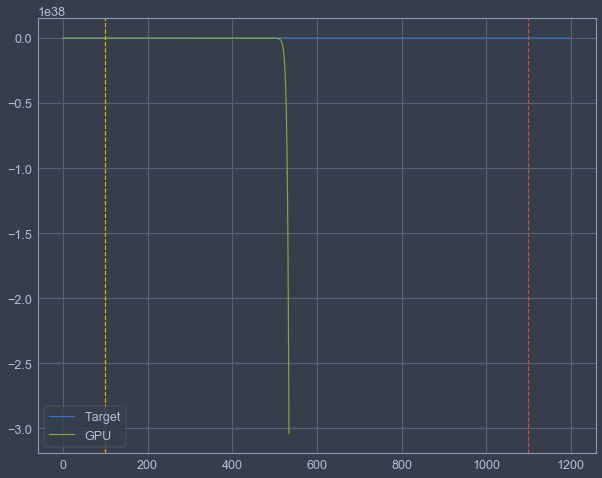

New Best Info a=0.069
 sr=5.318
 amp=0.195
 ri=0.926
 rr=0.527
 nrmse=1000.000
 KL 3.097


Iter: 0 #### Diagnostic 1000.000   Time 6.667 Best 313.669  KL 3.097 NRMSE 1000.000
MSE 1000.000   CM 1000.000
Iter: 1 #### Diagnostic 1000.000   Time 6.352 Best 313.669  KL 1000.000 NRMSE 1000.000
MSE 0.306   CM 0.044
Loss 0.3055209718446582   lc 0.013357151999139418


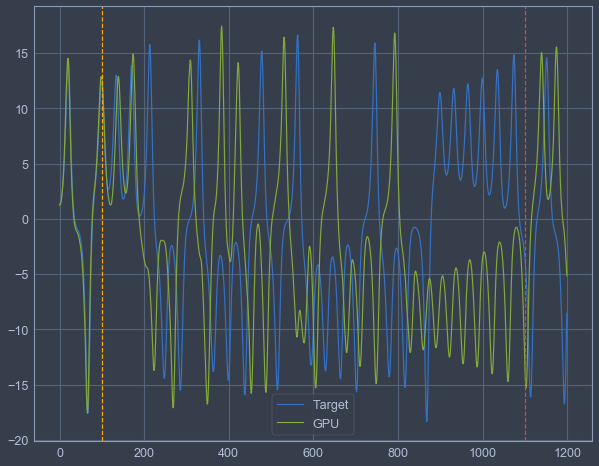

New Best Info a=0.714
 sr=4.144
 amp=0.786
 ri=0.588
 rr=3.684
 nrmse=0.306
 KL 0.523


Iter: 2 #### Diagnostic 0.306   Time 5.002 Best 0.013  KL 0.523 NRMSE 0.306
MSE 0.284   CM 0.363
Iter: 3 #### Diagnostic 0.284   Time 5.217 Best 0.013  KL 3.352 NRMSE 0.284
MSE 1000.000   CM 0.203
Iter: 4 #### Diagnostic 1000.000   Time 6.423 Best 0.013  KL 1.183 NRMSE 1000.000
MSE 0.279   CM 0.624
Iter: 5 #### Diagnostic 0.279   Time 4.536 Best 0.013  KL 12.615 NRMSE 0.279
MSE 1000.000   CM 1000.000
Iter: 6 #### Diagnostic 1000.000   Time 7.594 Best 0.013  KL 1000.000 NRMSE 1000.000
MSE 0.288   CM 0.066
Iter: 7 #### Diagnostic 0.288   Time 4.548 Best 0.013  KL 0.682 NRMSE 0.288
MSE 1000.000   CM 0.143
Iter: 8 #### Diagnostic 1000.000   Time 6.423 Best 0.013  KL 1.269 NRMSE 1000.000
MSE 0.325   CM 0.218
Iter: 9 #### Diagnostic 0.325   Time 5.223 Best 0.013  KL 2.457 NRMSE 0.325
MSE 1000.000   CM 0.174
Iter: 10 #### Diagnostic 1000.000   Time 6.807 Best 0.013  KL 1.951 NRMSE 1000.000
MSE 0.304   CM 0

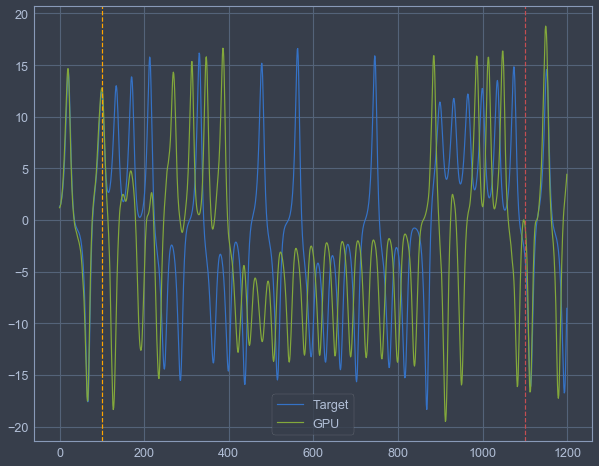

New Best Info a=0.797
 sr=7.720
 amp=0.432
 ri=0.649
 rr=2.470
 nrmse=0.280
 KL 0.286


Iter: 50 #### Diagnostic 0.280   Time 5.116 Best 0.007  KL 0.286 NRMSE 0.280
MSE 1000.000   CM 0.145
Iter: 51 #### Diagnostic 1000.000   Time 5.367 Best 0.007  KL 1.849 NRMSE 1000.000
MSE 1000.000   CM 0.305
Iter: 52 #### Diagnostic 1000.000   Time 6.704 Best 0.007  KL 2.465 NRMSE 1000.000
MSE 0.278   CM 0.054
Iter: 53 #### Diagnostic 0.278   Time 4.385 Best 0.007  KL 0.179 NRMSE 0.278
MSE 1000.000   CM 0.285
Iter: 54 #### Diagnostic 1000.000   Time 8.139 Best 0.007  KL 1.679 NRMSE 1000.000
MSE 1000.000   CM 0.201
Iter: 55 #### Diagnostic 1000.000   Time 6.513 Best 0.007  KL 2.221 NRMSE 1000.000
MSE 0.311   CM 0.166
Iter: 56 #### Diagnostic 0.311   Time 4.534 Best 0.007  KL 1.653 NRMSE 0.311
MSE 1000.000   CM 0.143
Iter: 57 #### Diagnostic 1000.000   Time 7.860 Best 0.007  KL 1.220 NRMSE 1000.000
MSE 1000.000   CM 0.143
Iter: 58 #### Diagnostic 1000.000   Time 8.145 Best 0.007  KL 1.428 NRMSE 1000.0

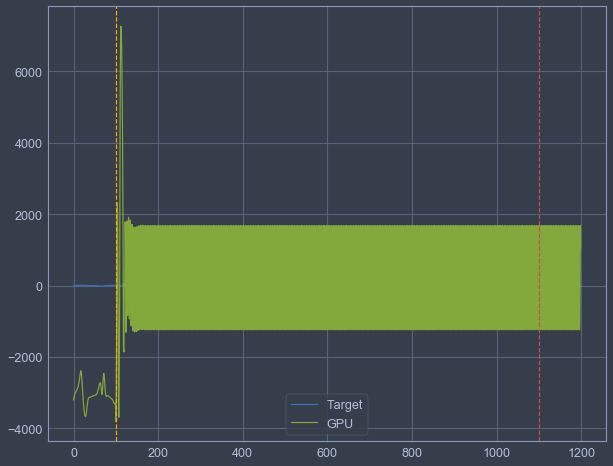

New Best Info a=0.516
 sr=6.506
 amp=0.979
 ri=0.295
 rr=0.003
 nrmse=34.748
 KL 1000.000


Iter: 104 #### Diagnostic 34.748   Time 8.692 Best 0.000  KL 1000.000 NRMSE 34.748
MSE 1000.000   CM 1000.000
Iter: 105 #### Diagnostic 1000.000   Time 6.122 Best 0.000  KL 1000.000 NRMSE 1000.000
MSE 1000.000   CM 1000.000
Iter: 106 #### Diagnostic 1000.000   Time 6.975 Best 0.000  KL 1000.000 NRMSE 1000.000
MSE 0.329   CM 0.060
Iter: 107 #### Diagnostic 0.329   Time 4.646 Best 0.000  KL 0.199 NRMSE 0.329
MSE 0.270   CM 0.068
Iter: 108 #### Diagnostic 0.270   Time 4.645 Best 0.000  KL 0.383 NRMSE 0.270
MSE 0.372   CM 0.390
Iter: 109 #### Diagnostic 0.372   Time 7.068 Best 0.000  KL 7.946 NRMSE 0.372
MSE 0.244   CM 0.027
Iter: 110 #### Diagnostic 0.244   Time 5.396 Best 0.000  KL 1000.000 NRMSE 0.244
MSE 0.306   CM 0.304
Iter: 111 #### Diagnostic 0.306   Time 4.585 Best 0.000  KL 6.238 NRMSE 0.306
MSE 0.313   CM 0.047
Iter: 112 #### Diagnostic 0.313   Time 4.671 Best 0.000  KL 0.191 NRMSE 0.313


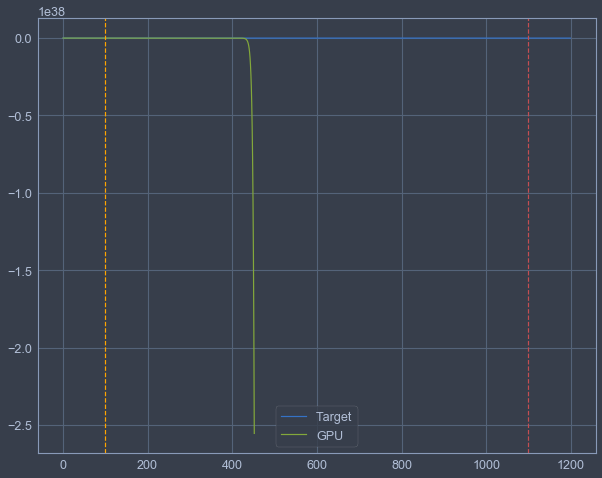

New Best Info a=0.069
 sr=5.318
 amp=0.195
 ri=0.926
 rr=0.527
 nrmse=1000.000
 KL 4.249


Iter: 0 #### Diagnostic 1000.000   Time 7.620 Best 434.204  KL 4.249 NRMSE 1000.000
MSE 1000.000   CM 1000.000
Iter: 1 #### Diagnostic 1000.000   Time 6.782 Best 434.204  KL 1000.000 NRMSE 1000.000
MSE 0.287   CM 0.054
Loss 0.28678966383155524   lc 0.015401240188363247


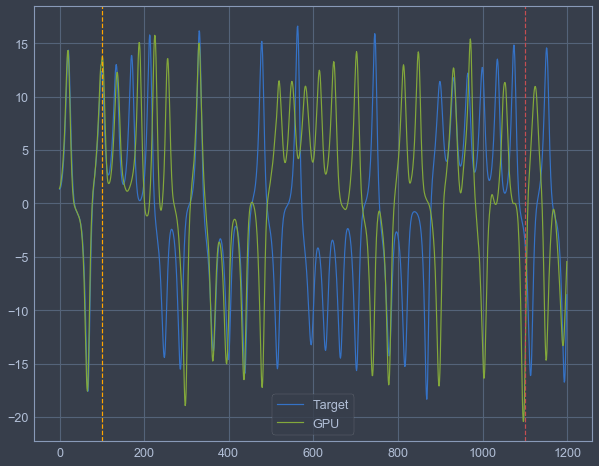

New Best Info a=0.714
 sr=4.144
 amp=0.786
 ri=0.588
 rr=3.684
 nrmse=0.287
 KL 0.545


Iter: 2 #### Diagnostic 0.287   Time 5.261 Best 0.015  KL 0.545 NRMSE 0.287
MSE 0.306   CM 0.048
Loss 0.3059984447131747   lc 0.014770823212719749


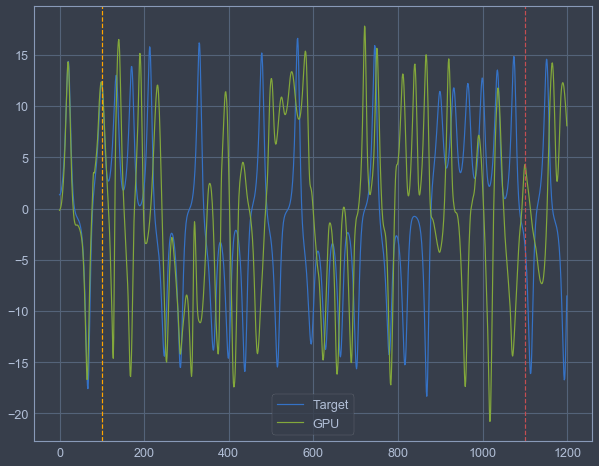

New Best Info a=0.673
 sr=7.761
 amp=0.989
 ri=0.778
 rr=0.127
 nrmse=0.306
 KL 1000.000


Iter: 3 #### Diagnostic 0.306   Time 5.652 Best 0.015  KL 1000.000 NRMSE 0.306
MSE 1000.000   CM 0.158
Iter: 4 #### Diagnostic 1000.000   Time 6.835 Best 0.015  KL 0.992 NRMSE 1000.000
MSE 0.296   CM 0.746
Iter: 5 #### Diagnostic 0.296   Time 4.412 Best 0.015  KL 11.410 NRMSE 0.296
MSE 1000.000   CM 1000.000
Iter: 6 #### Diagnostic 1000.000   Time 8.175 Best 0.015  KL 1000.000 NRMSE 1000.000
MSE 0.293   CM 0.060
Iter: 7 #### Diagnostic 0.293   Time 5.180 Best 0.015  KL 0.423 NRMSE 0.293
MSE 1000.000   CM 0.165
Iter: 8 #### Diagnostic 1000.000   Time 8.394 Best 0.015  KL 1.035 NRMSE 1000.000
MSE 0.286   CM 0.294
Iter: 9 #### Diagnostic 0.286   Time 5.090 Best 0.015  KL 5.434 NRMSE 0.286
MSE 1000.000   CM 0.298
Iter: 10 #### Diagnostic 1000.000   Time 6.734 Best 0.015  KL 3.007 NRMSE 1000.000
MSE 0.328   CM 0.186
Iter: 11 #### Diagnostic 0.328   Time 4.815 Best 0.015  KL 2.577 NRMSE 0.328
MSE 0.304

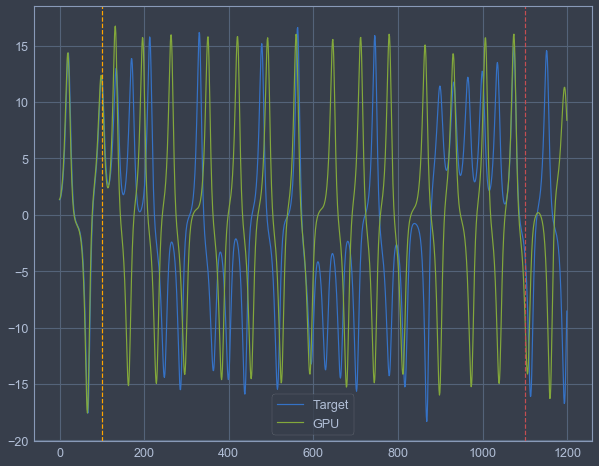

New Best Info a=0.595
 sr=0.859
 amp=0.210
 ri=0.860
 rr=3.557
 nrmse=0.289
 KL 0.585


Iter: 19 #### Diagnostic 0.289   Time 5.950 Best 0.015  KL 0.585 NRMSE 0.289
MSE 0.282   CM 0.096
Iter: 20 #### Diagnostic 0.282   Time 5.010 Best 0.015  KL 0.854 NRMSE 0.282
MSE 1000.000   CM 0.196
Iter: 21 #### Diagnostic 1000.000   Time 6.277 Best 0.015  KL 1.436 NRMSE 1000.000
MSE 1000.000   CM 0.290
Iter: 22 #### Diagnostic 1000.000   Time 7.554 Best 0.015  KL 2.443 NRMSE 1000.000
MSE 0.267   CM 0.424
Iter: 23 #### Diagnostic 0.267   Time 6.148 Best 0.015  KL 5.339 NRMSE 0.267
MSE 0.660   CM 0.059
Iter: 24 #### Diagnostic 0.660   Time 7.431 Best 0.015  KL 0.175 NRMSE 0.660
MSE 29.356   CM 0.154
Iter: 25 #### Diagnostic 29.356   Time 8.023 Best 0.015  KL 0.508 NRMSE 29.356
MSE 1000.000   CM 0.097
Iter: 26 #### Diagnostic 1000.000   Time 5.621 Best 0.015  KL 1.223 NRMSE 1000.000
MSE 1000.000   CM 0.213
Iter: 27 #### Diagnostic 1000.000   Time 8.485 Best 0.015  KL 1.835 NRMSE 1000.000
MSE 0.899   

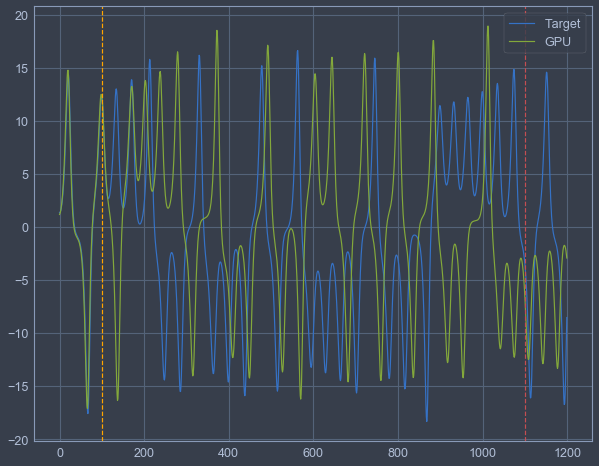

New Best Info a=0.564
 sr=4.678
 amp=0.402
 ri=0.118
 rr=0.586
 nrmse=0.313
 KL 0.304


Iter: 63 #### Diagnostic 0.313   Time 5.836 Best 0.006  KL 0.304 NRMSE 0.313
MSE 1000.000   CM 1000.000
Iter: 64 #### Diagnostic 1000.000   Time 6.093 Best 0.006  KL 1000.000 NRMSE 1000.000
MSE 1000.000   CM 0.269
Iter: 65 #### Diagnostic 1000.000   Time 5.600 Best 0.006  KL 3.092 NRMSE 1000.000
MSE 1000.000   CM 0.062
Iter: 66 #### Diagnostic 1000.000   Time 6.041 Best 0.006  KL 0.020 NRMSE 1000.000
MSE 1000.000   CM 0.229
Iter: 67 #### Diagnostic 1000.000   Time 7.191 Best 0.006  KL 1.822 NRMSE 1000.000
MSE 1.608   CM 0.699
Iter: 68 #### Diagnostic 1.608   Time 7.102 Best 0.006  KL 14.308 NRMSE 1.608
MSE 1000.000   CM 0.272
Iter: 69 #### Diagnostic 1000.000   Time 5.252 Best 0.006  KL 2.254 NRMSE 1000.000
MSE 0.297   CM 0.068
Iter: 70 #### Diagnostic 0.297   Time 5.132 Best 0.006  KL 0.191 NRMSE 0.297
MSE 1000.000   CM 0.204
Iter: 71 #### Diagnostic 1000.000   Time 6.126 Best 0.006  KL 2.462 NRMSE

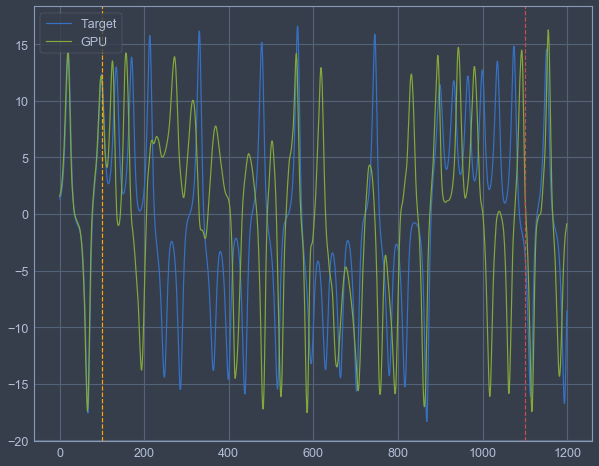

New Best Info a=0.872
 sr=6.016
 amp=0.878
 ri=0.623
 rr=3.288
 nrmse=0.262
 KL 0.076


Iter: 108 #### Diagnostic 0.262   Time 4.598 Best 0.006  KL 0.076 NRMSE 0.262
MSE 0.294   CM 0.081
Iter: 109 #### Diagnostic 0.294   Time 4.577 Best 0.006  KL 0.300 NRMSE 0.294
MSE 0.309   CM 0.055
Iter: 110 #### Diagnostic 0.309   Time 4.854 Best 0.006  KL 0.133 NRMSE 0.309
MSE 0.269   CM 0.252
Iter: 111 #### Diagnostic 0.269   Time 4.891 Best 0.006  KL 3.183 NRMSE 0.269
MSE 0.300   CM 0.303
Iter: 112 #### Diagnostic 0.300   Time 4.553 Best 0.006  KL 9.800 NRMSE 0.300
MSE 0.264   CM 0.020
Loss 0.26413459197166256   lc 0.005339634386304415


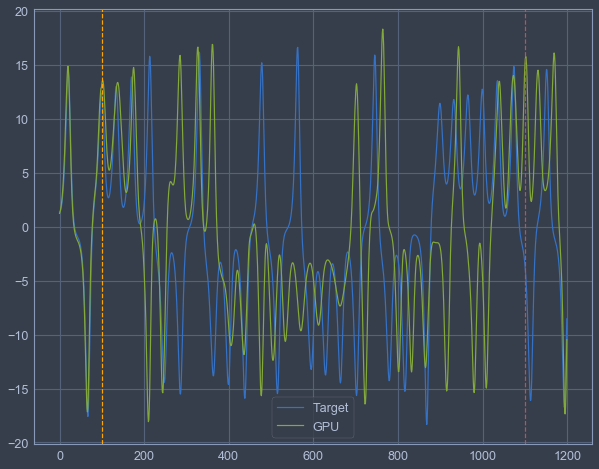

New Best Info a=0.450
 sr=5.942
 amp=0.834
 ri=0.645
 rr=1.943
 nrmse=0.264
 KL 1000.000


Iter: 113 #### Diagnostic 0.264   Time 4.579 Best 0.005  KL 1000.000 NRMSE 0.264
MSE 0.303   CM 0.107
Iter: 114 #### Diagnostic 0.303   Time 4.661 Best 0.005  KL 0.937 NRMSE 0.303
MSE 0.260   CM 0.120
Iter: 115 #### Diagnostic 0.260   Time 4.459 Best 0.005  KL 1.418 NRMSE 0.260
MSE 0.286   CM 0.103
Iter: 116 #### Diagnostic 0.286   Time 4.552 Best 0.005  KL 0.398 NRMSE 0.286
MSE 0.277   CM 0.126
Iter: 117 #### Diagnostic 0.277   Time 5.056 Best 0.005  KL 1.099 NRMSE 0.277
MSE 0.315   CM 0.561
Iter: 118 #### Diagnostic 0.315   Time 4.824 Best 0.005  KL 8.958 NRMSE 0.315
MSE 0.337   CM 0.029
Iter: 119 #### Diagnostic 0.337   Time 4.772 Best 0.005  KL 1000.000 NRMSE 0.337
MSE 0.287   CM 0.228
Iter: 120 #### Diagnostic 0.287   Time 4.531 Best 0.005  KL 6.334 NRMSE 0.287
MSE 0.309   CM 0.057
Iter: 121 #### Diagnostic 0.309   Time 4.473 Best 0.005  KL 0.385 NRMSE 0.309
MSE 0.300   CM 0.491
Iter: 122 ##

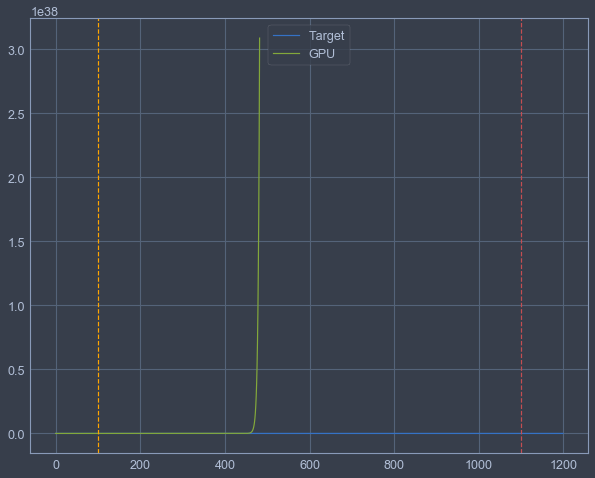

New Best Info a=0.069
 sr=5.318
 amp=0.195
 ri=0.926
 rr=0.527
 nrmse=1000.000
 KL 2.292


Iter: 0 #### Diagnostic 1000.000   Time 5.649 Best 270.275  KL 2.292 NRMSE 1000.000
MSE 1000.000   CM 1000.000
Iter: 1 #### Diagnostic 1000.000   Time 6.823 Best 270.275  KL 1000.000 NRMSE 1000.000
MSE 0.296   CM 0.022
Loss 0.2962271945656458   lc 0.006618271734486935


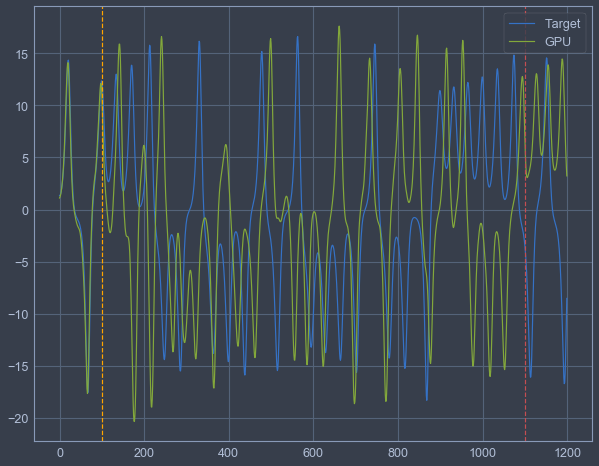

New Best Info a=0.714
 sr=4.144
 amp=0.786
 ri=0.588
 rr=3.684
 nrmse=0.296
 KL 0.115


Iter: 2 #### Diagnostic 0.296   Time 4.530 Best 0.007  KL 0.115 NRMSE 0.296
MSE 0.272   CM 0.317
Iter: 3 #### Diagnostic 0.272   Time 4.486 Best 0.007  KL 4.719 NRMSE 0.272
MSE 1000.000   CM 0.105
Iter: 4 #### Diagnostic 1000.000   Time 7.399 Best 0.007  KL 0.714 NRMSE 1000.000
MSE 0.293   CM 0.377
Iter: 5 #### Diagnostic 0.293   Time 4.256 Best 0.007  KL 4.527 NRMSE 0.293
MSE 1000.000   CM 1000.000
Iter: 6 #### Diagnostic 1000.000   Time 5.540 Best 0.007  KL 1000.000 NRMSE 1000.000
MSE 0.307   CM 0.296
Iter: 7 #### Diagnostic 0.307   Time 4.928 Best 0.007  KL 2.502 NRMSE 0.307
MSE 1000.000   CM 0.173
Iter: 8 #### Diagnostic 1000.000   Time 5.687 Best 0.007  KL 1.243 NRMSE 1000.000
MSE 0.310   CM 0.483
Iter: 9 #### Diagnostic 0.310   Time 4.414 Best 0.007  KL 9.127 NRMSE 0.310
MSE 1000.000   CM 0.151
Iter: 10 #### Diagnostic 1000.000   Time 5.051 Best 0.007  KL 1.648 NRMSE 1000.000
MSE 0.317   CM 0.

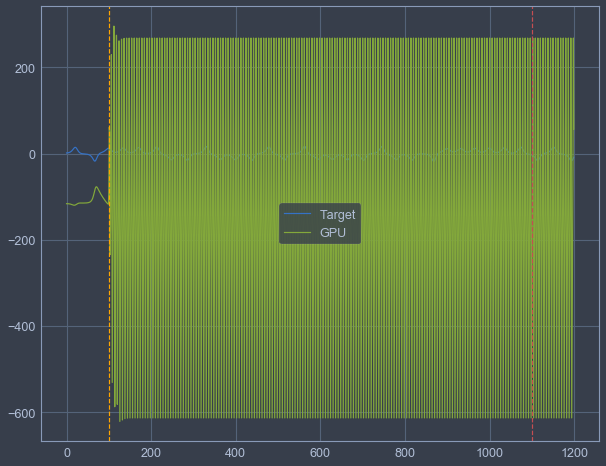

New Best Info a=0.924
 sr=5.924
 amp=0.320
 ri=0.025
 rr=4.308
 nrmse=8.773
 KL 1000.000


Iter: 17 #### Diagnostic 8.773   Time 7.938 Best 0.000  KL 1000.000 NRMSE 8.773
MSE 1000.000   CM 0.219
Iter: 18 #### Diagnostic 1000.000   Time 6.106 Best 0.000  KL 2.019 NRMSE 1000.000
MSE 1000.000   CM 0.199
Iter: 19 #### Diagnostic 1000.000   Time 5.771 Best 0.000  KL 2.242 NRMSE 1000.000
MSE 0.306   CM 0.098
Iter: 20 #### Diagnostic 0.306   Time 4.543 Best 0.000  KL 0.455 NRMSE 0.306
MSE 1000.000   CM 0.104
Iter: 21 #### Diagnostic 1000.000   Time 5.692 Best 0.000  KL 0.115 NRMSE 1000.000
MSE 1000.000   CM 0.260
Iter: 22 #### Diagnostic 1000.000   Time 5.420 Best 0.000  KL 2.447 NRMSE 1000.000
MSE 0.283   CM 0.083
Iter: 23 #### Diagnostic 0.283   Time 4.481 Best 0.000  KL 0.495 NRMSE 0.283
MSE 1000.000   CM 0.073
Iter: 24 #### Diagnostic 1000.000   Time 5.198 Best 0.000  KL 0.712 NRMSE 1000.000
MSE 13.244   CM 0.050
Iter: 25 #### Diagnostic 13.244   Time 5.836 Best 0.000  KL 1000.000 NRMSE 1

MSE 0.340   CM 0.640
Iter: 94 #### Diagnostic 0.340   Time 5.983 Best 0.000  KL 10.323 NRMSE 0.340
MSE 1000.000   CM 0.075
Iter: 95 #### Diagnostic 1000.000   Time 4.935 Best 0.000  KL 0.792 NRMSE 1000.000
MSE 1000.000   CM 0.210
Iter: 96 #### Diagnostic 1000.000   Time 6.330 Best 0.000  KL 1.341 NRMSE 1000.000
MSE 1000.000   CM 0.213
Iter: 97 #### Diagnostic 1000.000   Time 5.231 Best 0.000  KL 2.414 NRMSE 1000.000
MSE 1000.000   CM 0.123
Iter: 98 #### Diagnostic 1000.000   Time 5.702 Best 0.000  KL 1.503 NRMSE 1000.000
MSE 0.266   CM 0.099
Iter: 99 #### Diagnostic 0.266   Time 6.152 Best 0.000  KL 1.336 NRMSE 0.266
MSE 149046390571706315205693921034240.000   CM 0.310
Iter: 100 #### Diagnostic 1000.000   Time 5.864 Best 0.000  KL 3.174 NRMSE 149046390571706315205693921034240.000
MSE 0.297   CM 0.077
Iter: 101 #### Diagnostic 0.297   Time 4.829 Best 0.000  KL 0.629 NRMSE 0.297
MSE 0.454   CM 0.310
Iter: 102 #### Diagnostic 0.454   Time 4.624 Best 0.000  KL 2.300 NRMSE 0.454
MSE 0.367  

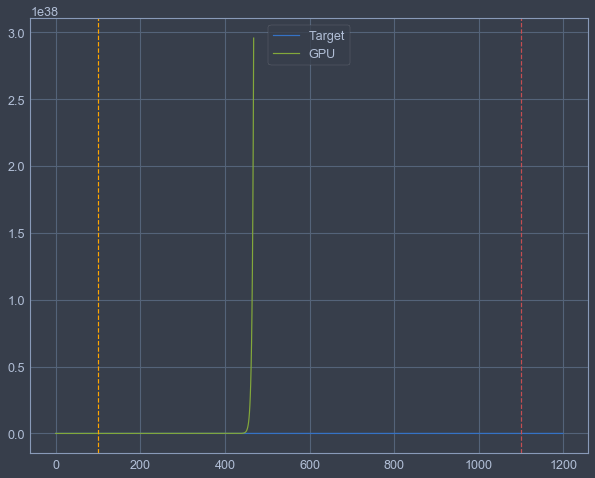

New Best Info a=0.069
 sr=5.318
 amp=0.195
 ri=0.926
 rr=0.527
 nrmse=1000.000
 KL 4.088


Iter: 0 #### Diagnostic 1000.000   Time 5.882 Best 416.089  KL 4.088 NRMSE 1000.000
MSE 1000.000   CM 1000.000
Iter: 1 #### Diagnostic 1000.000   Time 5.706 Best 416.089  KL 1000.000 NRMSE 1000.000
MSE 0.299   CM 0.038
Loss 0.2990647146683778   lc 0.011241576435917014


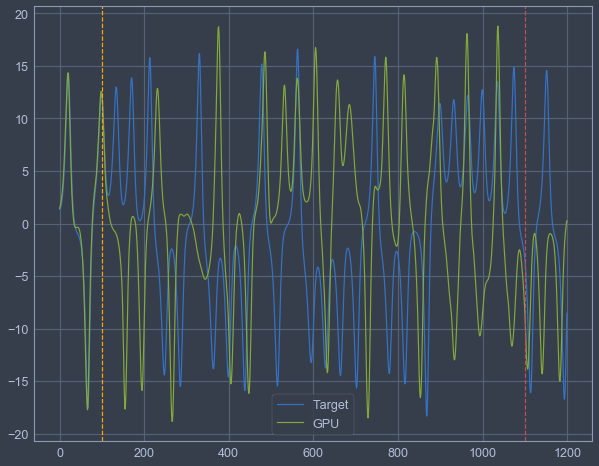

New Best Info a=0.714
 sr=4.144
 amp=0.786
 ri=0.588
 rr=3.684
 nrmse=0.299
 KL 0.321


Iter: 2 #### Diagnostic 0.299   Time 4.678 Best 0.011  KL 0.321 NRMSE 0.299
MSE 15016.546   CM 0.074
Iter: 3 #### Diagnostic 1000.000   Time 5.681 Best 0.011  KL 0.713 NRMSE 15016.546
MSE 1000.000   CM 0.238
Iter: 4 #### Diagnostic 1000.000   Time 5.555 Best 0.011  KL 2.632 NRMSE 1000.000
MSE 0.316   CM 0.251
Iter: 5 #### Diagnostic 0.316   Time 4.590 Best 0.011  KL 2.788 NRMSE 0.316
MSE 1.395   CM 0.225
Iter: 6 #### Diagnostic 1.395   Time 4.888 Best 0.011  KL 1.452 NRMSE 1.395
MSE 0.281   CM 0.086
Iter: 7 #### Diagnostic 0.281   Time 4.561 Best 0.011  KL 0.926 NRMSE 0.281
MSE 1000.000   CM 0.329
Iter: 8 #### Diagnostic 1000.000   Time 6.549 Best 0.011  KL 2.059 NRMSE 1000.000
MSE 0.270   CM 0.221
Iter: 9 #### Diagnostic 0.270   Time 7.202 Best 0.011  KL 2.155 NRMSE 0.270
MSE 1000.000   CM 0.248
Iter: 10 #### Diagnostic 1000.000   Time 5.696 Best 0.011  KL 2.238 NRMSE 1000.000
MSE 0.318   CM 0.741


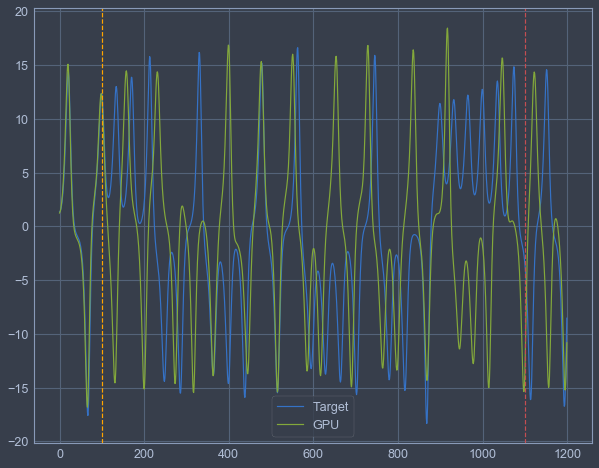

New Best Info a=0.305
 sr=5.580
 amp=0.781
 ri=0.460
 rr=3.231
 nrmse=0.265
 KL 0.468


Iter: 23 #### Diagnostic 0.265   Time 6.076 Best 0.010  KL 0.468 NRMSE 0.265
MSE 1000.000   CM 0.119
Iter: 24 #### Diagnostic 1000.000   Time 5.587 Best 0.010  KL 0.779 NRMSE 1000.000
MSE 1.340   CM 0.249
Iter: 25 #### Diagnostic 1.340   Time 6.690 Best 0.010  KL 1.602 NRMSE 1.340
MSE 0.307   CM 0.796
Iter: 26 #### Diagnostic 0.307   Time 4.217 Best 0.010  KL 20.033 NRMSE 0.307
MSE 1000.000   CM 0.257
Iter: 27 #### Diagnostic 1000.000   Time 5.447 Best 0.010  KL 2.177 NRMSE 1000.000
MSE 1000.000   CM 0.055
Iter: 28 #### Diagnostic 1000.000   Time 7.178 Best 0.010  KL 0.011 NRMSE 1000.000
MSE 0.313   CM 0.579
Iter: 29 #### Diagnostic 0.313   Time 5.534 Best 0.010  KL 10.574 NRMSE 0.313
MSE 0.282   CM 0.036
Iter: 30 #### Diagnostic 0.282   Time 5.346 Best 0.010  KL 0.186 NRMSE 0.282
MSE 1000.000   CM 0.128
Iter: 31 #### Diagnostic 1000.000   Time 6.333 Best 0.010  KL 1.205 NRMSE 1000.000
MSE 0.274   C

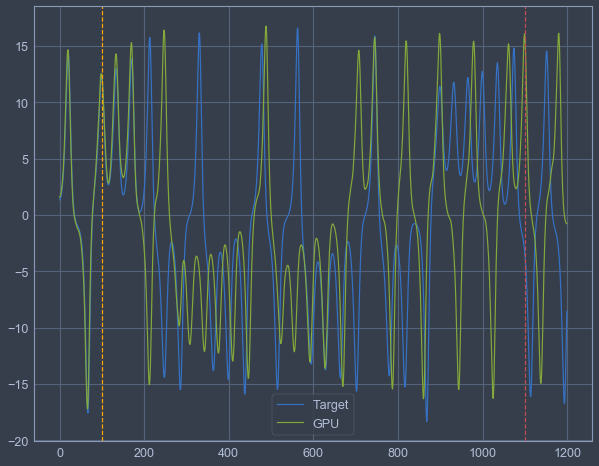

New Best Info a=0.797
 sr=7.720
 amp=0.432
 ri=0.649
 rr=2.470
 nrmse=0.248
 KL 0.163


Iter: 50 #### Diagnostic 0.248   Time 5.260 Best 0.006  KL 0.163 NRMSE 0.248
MSE 0.312   CM 0.028
Iter: 51 #### Diagnostic 0.312   Time 4.697 Best 0.006  KL 0.426 NRMSE 0.312
MSE 1000.000   CM 0.271
Iter: 52 #### Diagnostic 1000.000   Time 6.291 Best 0.006  KL 2.354 NRMSE 1000.000
MSE 0.264   CM 0.184
Iter: 53 #### Diagnostic 0.264   Time 4.876 Best 0.006  KL 1.880 NRMSE 0.264
MSE 1000.000   CM 0.230
Iter: 54 #### Diagnostic 1000.000   Time 6.253 Best 0.006  KL 1.681 NRMSE 1000.000
MSE 1000.000   CM 0.149
Iter: 55 #### Diagnostic 1000.000   Time 4.970 Best 0.006  KL 1.893 NRMSE 1000.000
MSE 0.310   CM 0.107
Iter: 56 #### Diagnostic 0.310   Time 6.230 Best 0.006  KL 1.565 NRMSE 0.310
MSE 0.330   CM 0.648
Iter: 57 #### Diagnostic 0.330   Time 7.386 Best 0.006  KL 11.847 NRMSE 0.330
MSE 1000.000   CM 0.108
Iter: 58 #### Diagnostic 1000.000   Time 5.256 Best 0.006  KL 1.003 NRMSE 1000.000
MSE 1000.000  

MSE 0.264   CM 0.431
Iter: 129 #### Diagnostic 0.264   Time 4.514 Best 0.006  KL 8.006 NRMSE 0.264
MSE 0.314   CM 0.028
Iter: 130 #### Diagnostic 0.314   Time 4.924 Best 0.006  KL 0.044 NRMSE 0.314
MSE 0.286   CM 0.515
Iter: 131 #### Diagnostic 0.286   Time 4.795 Best 0.006  KL 5.376 NRMSE 0.286
MSE 0.316   CM 0.120
Iter: 132 #### Diagnostic 0.316   Time 5.188 Best 0.006  KL 1.091 NRMSE 0.316
MSE 0.300   CM 0.044
Iter: 133 #### Diagnostic 0.300   Time 4.751 Best 0.006  KL 0.495 NRMSE 0.300
MSE 0.324   CM 0.350
Iter: 134 #### Diagnostic 0.324   Time 4.936 Best 0.006  KL 6.919 NRMSE 0.324
MSE 0.290   CM 0.083
Iter: 135 #### Diagnostic 0.290   Time 4.054 Best 0.006  KL 0.716 NRMSE 0.290
MSE 0.293   CM 0.377
Iter: 136 #### Diagnostic 0.293   Time 4.900 Best 0.006  KL 4.085 NRMSE 0.293
MSE 0.296   CM 0.238
Iter: 137 #### Diagnostic 0.296   Time 4.412 Best 0.006  KL 2.305 NRMSE 0.296
MSE 1000.000   CM 1000.000
Iter: 138 #### Diagnostic 1000.000   Time 4.785 Best 0.006  KL 1000.000 NRMSE 1000

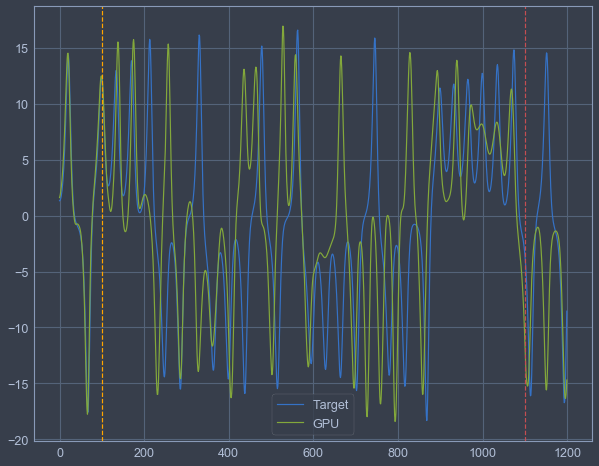

New Best Info a=0.461
 sr=6.111
 amp=0.778
 ri=0.677
 rr=2.058
 nrmse=0.233
 KL 0.063


Iter: 142 #### Diagnostic 0.233   Time 4.968 Best 0.005  KL 0.063 NRMSE 0.233
MSE 0.303   CM 0.126
Iter: 143 #### Diagnostic 0.303   Time 4.849 Best 0.005  KL 1.780 NRMSE 0.303
MSE 0.304   CM 0.039
Iter: 144 #### Diagnostic 0.304   Time 4.611 Best 0.005  KL 0.268 NRMSE 0.304
MSE 0.261   CM 0.631
Iter: 145 #### Diagnostic 0.261   Time 4.576 Best 0.005  KL 8.614 NRMSE 0.261
MSE 0.288   CM 0.028
Iter: 146 #### Diagnostic 0.288   Time 4.817 Best 0.005  KL 0.264 NRMSE 0.288
MSE 0.305   CM 0.114
Iter: 147 #### Diagnostic 0.305   Time 4.676 Best 0.005  KL 0.858 NRMSE 0.305
MSE 0.253   CM 0.339
Iter: 148 #### Diagnostic 0.253   Time 4.697 Best 0.005  KL 4.338 NRMSE 0.253
MSE 0.269   CM 0.023
Iter: 149 #### Diagnostic 0.269   Time 4.792 Best 0.005  KL 0.059 NRMSE 0.269

Best result = 0.23336801981771763
a = 0.4607952089448878
sr = 6.1113333848198135
amp = 0.7775496025175925
ri = 0.6766153963889747
rr = 2.058

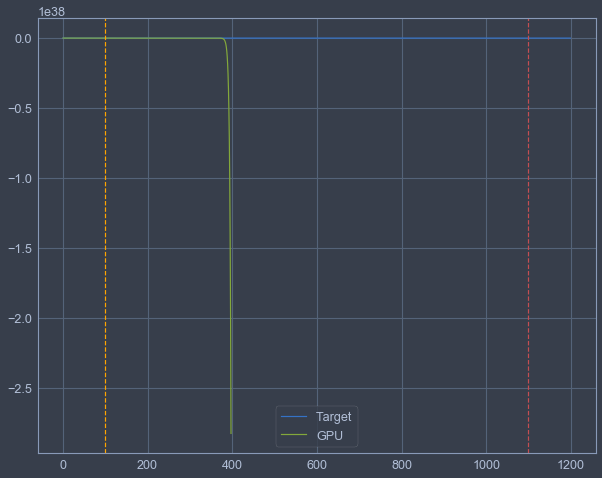

New Best Info a=0.069
 sr=5.318
 amp=0.195
 ri=0.926
 rr=0.527
 nrmse=1000.000
 KL 1.925


Iter: 0 #### Diagnostic 1000.000   Time 6.315 Best 255.633  KL 1.925 NRMSE 1000.000
MSE 1000.000   CM 1000.000
Iter: 1 #### Diagnostic 1000.000   Time 5.397 Best 255.633  KL 1000.000 NRMSE 1000.000
MSE 0.309   CM 0.032
Loss 0.30910735032147446   lc 0.009911031027534304


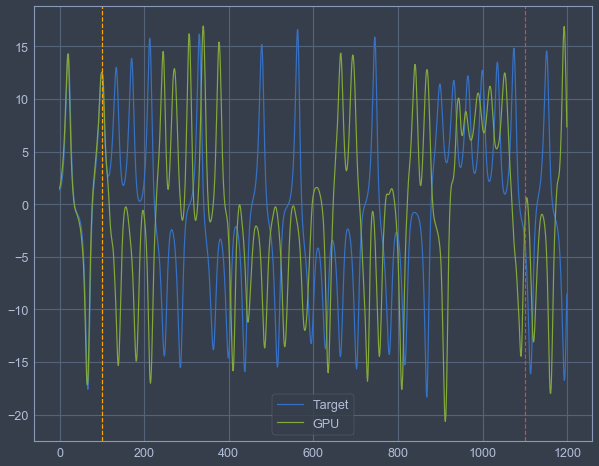

New Best Info a=0.714
 sr=4.144
 amp=0.786
 ri=0.588
 rr=3.684
 nrmse=0.309
 KL 0.201


Iter: 2 #### Diagnostic 0.309   Time 4.744 Best 0.010  KL 0.201 NRMSE 0.309
MSE 0.291   CM 0.053
Iter: 3 #### Diagnostic 0.291   Time 4.678 Best 0.010  KL 0.210 NRMSE 0.291
MSE 0.282   CM 0.079
Iter: 4 #### Diagnostic 0.282   Time 5.027 Best 0.010  KL 0.805 NRMSE 0.282
MSE 0.339   CM 0.221
Iter: 5 #### Diagnostic 0.339   Time 4.683 Best 0.010  KL 2.162 NRMSE 0.339
MSE 1000.000   CM 1000.000
Iter: 6 #### Diagnostic 1000.000   Time 5.334 Best 0.010  KL 1000.000 NRMSE 1000.000
MSE 0.301   CM 0.034
Iter: 7 #### Diagnostic 0.301   Time 4.469 Best 0.010  KL 0.195 NRMSE 0.301
MSE 1000.000   CM 0.311
Iter: 8 #### Diagnostic 1000.000   Time 7.136 Best 0.010  KL 2.835 NRMSE 1000.000
MSE 0.309   CM 0.053
Iter: 9 #### Diagnostic 0.309   Time 4.953 Best 0.010  KL 0.458 NRMSE 0.309
MSE 1000.000   CM 0.326
Iter: 10 #### Diagnostic 1000.000   Time 5.773 Best 0.010  KL 2.866 NRMSE 1000.000
MSE 0.290   CM 0.169
Iter:

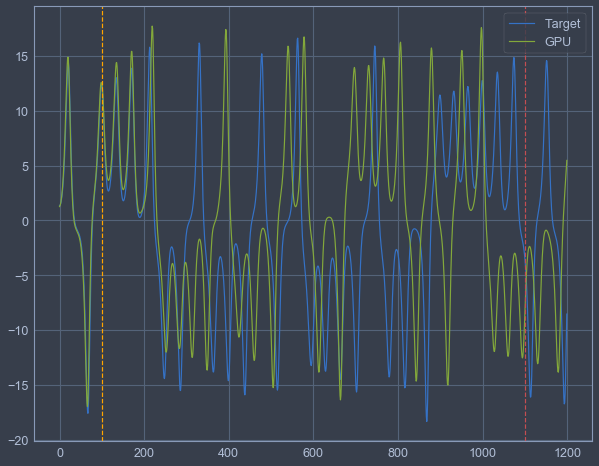

New Best Info a=0.335
 sr=4.015
 amp=0.721
 ri=0.373
 rr=0.794
 nrmse=0.269
 KL 0.180


Iter: 12 #### Diagnostic 0.269   Time 5.698 Best 0.007  KL 0.180 NRMSE 0.269
MSE 0.294   CM 0.443
Iter: 13 #### Diagnostic 0.294   Time 6.594 Best 0.007  KL 5.810 NRMSE 0.294
MSE 0.291   CM 0.012
Loss 0.29054187850528723   lc 0.003511050531830168


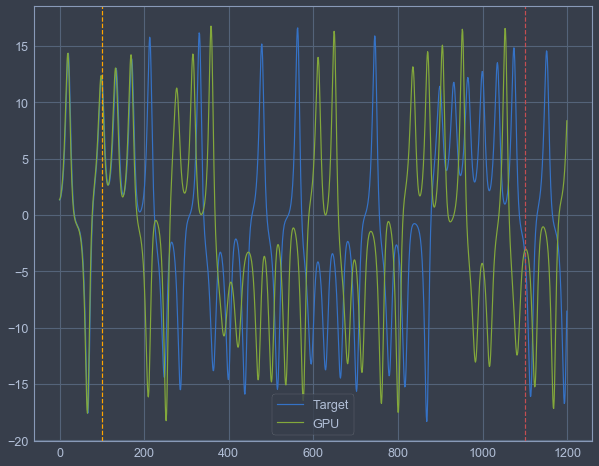

New Best Info a=0.285
 sr=5.831
 amp=0.275
 ri=0.097
 rr=4.869
 nrmse=0.291
 KL 0.109


Iter: 14 #### Diagnostic 0.291   Time 6.470 Best 0.004  KL 0.109 NRMSE 0.291
MSE 1000.000   CM 0.110
Iter: 15 #### Diagnostic 1000.000   Time 8.236 Best 0.004  KL 0.742 NRMSE 1000.000
MSE 0.292   CM 0.063
Iter: 16 #### Diagnostic 0.292   Time 6.075 Best 0.004  KL 0.353 NRMSE 0.292
MSE 6.947   CM 0.282
Iter: 17 #### Diagnostic 6.947   Time 5.593 Best 0.004  KL 1.913 NRMSE 6.947
MSE 1000.000   CM 0.206
Iter: 18 #### Diagnostic 1000.000   Time 7.258 Best 0.004  KL 1.622 NRMSE 1000.000
MSE 0.233   CM 0.055
Iter: 19 #### Diagnostic 0.233   Time 5.484 Best 0.004  KL 0.707 NRMSE 0.233
MSE 0.315   CM 0.358
Iter: 20 #### Diagnostic 0.315   Time 4.444 Best 0.004  KL 4.025 NRMSE 0.315
MSE 1000.000   CM 0.076
Iter: 21 #### Diagnostic 1000.000   Time 7.549 Best 0.004  KL 0.011 NRMSE 1000.000
MSE 1000.000   CM 0.163
Iter: 22 #### Diagnostic 1000.000   Time 5.672 Best 0.004  KL 1.085 NRMSE 1000.000
MSE 0.295   CM 

MSE 1000.000   CM 0.208
Iter: 92 #### Diagnostic 1000.000   Time 5.390 Best 0.004  KL 1.554 NRMSE 1000.000
MSE 1000.000   CM 0.148
Iter: 93 #### Diagnostic 1000.000   Time 5.588 Best 0.004  KL 1.695 NRMSE 1000.000
MSE 0.347   CM 0.582
Iter: 94 #### Diagnostic 0.347   Time 5.488 Best 0.004  KL 8.164 NRMSE 0.347
MSE 1000.000   CM 0.218
Iter: 95 #### Diagnostic 1000.000   Time 6.717 Best 0.004  KL 1.802 NRMSE 1000.000
MSE 1000.000   CM 0.182
Iter: 96 #### Diagnostic 1000.000   Time 5.553 Best 0.004  KL 1.724 NRMSE 1000.000
MSE 1000.000   CM 0.278
Iter: 97 #### Diagnostic 1000.000   Time 5.833 Best 0.004  KL 3.028 NRMSE 1000.000
MSE 1000.000   CM 0.225
Iter: 98 #### Diagnostic 1000.000   Time 5.346 Best 0.004  KL 2.347 NRMSE 1000.000
MSE 0.290   CM 0.314
Iter: 99 #### Diagnostic 0.290   Time 6.515 Best 0.004  KL 3.828 NRMSE 0.290
MSE 0.309   CM 0.050
Iter: 100 #### Diagnostic 0.309   Time 4.479 Best 0.004  KL 0.317 NRMSE 0.309
MSE 104.758   CM 1000.000
Iter: 101 #### Diagnostic 104.758   T

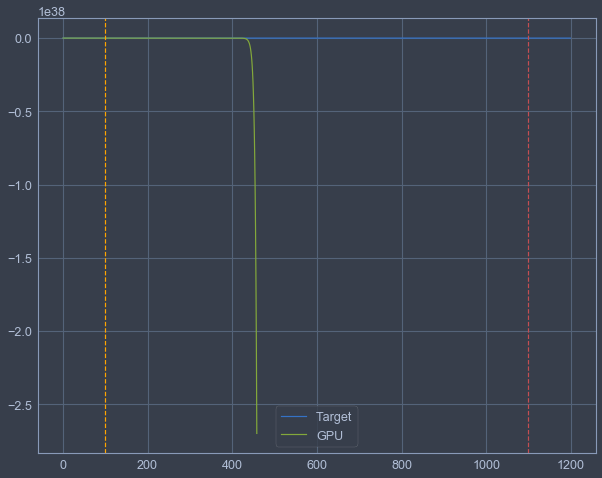

New Best Info a=0.924
 sr=5.421
 amp=0.988
 ri=0.470
 rr=4.118
 nrmse=1000.000
 KL 1000.000


Iter: 148 #### Diagnostic 1000.000   Time 6.253 Best 0.000  KL 1000.000 NRMSE 1000.000
MSE 0.300   CM 0.028
Iter: 149 #### Diagnostic 0.300   Time 5.849 Best 0.000  KL 0.288 NRMSE 0.300

Best result = 0.2330568709242945
a = 0.5948354975324227
sr = 0.8585825609248062
amp = 0.2100805936309223
ri = 0.8604663626103327
rr = 3.557430118528141
********** 700 ***********
MSE 1000.000   CM 0.420
Loss 1000   lc 420.05375445596303


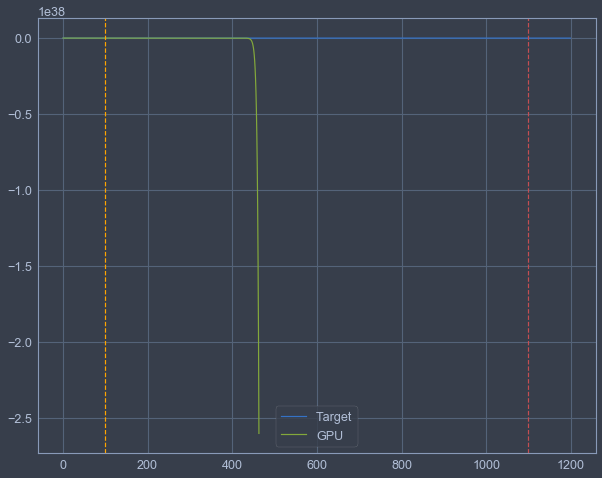

New Best Info a=0.069
 sr=5.318
 amp=0.195
 ri=0.926
 rr=0.527
 nrmse=1000.000
 KL 3.833


Iter: 0 #### Diagnostic 1000.000   Time 5.431 Best 420.054  KL 3.833 NRMSE 1000.000
MSE 1000.000   CM 1000.000
Iter: 1 #### Diagnostic 1000.000   Time 5.235 Best 420.054  KL 1000.000 NRMSE 1000.000
MSE 0.301   CM 0.373
Loss 0.30059973627347597   lc 0.11217037739917154


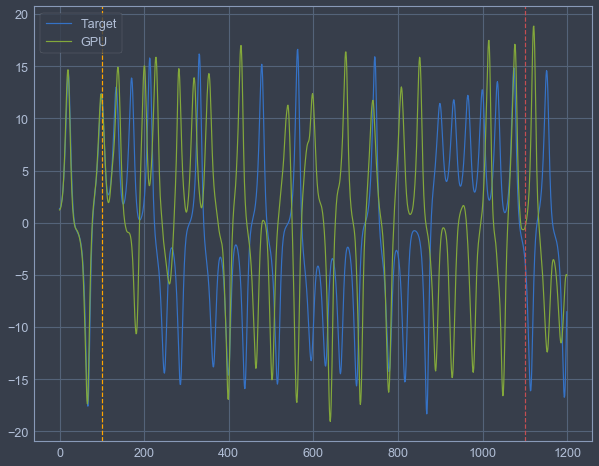

New Best Info a=0.714
 sr=4.144
 amp=0.786
 ri=0.588
 rr=3.684
 nrmse=0.301
 KL 3.350


Iter: 2 #### Diagnostic 0.301   Time 4.883 Best 0.112  KL 3.350 NRMSE 0.301
MSE 0.276   CM 0.153
Loss 0.2758417306894306   lc 0.042147478954679615


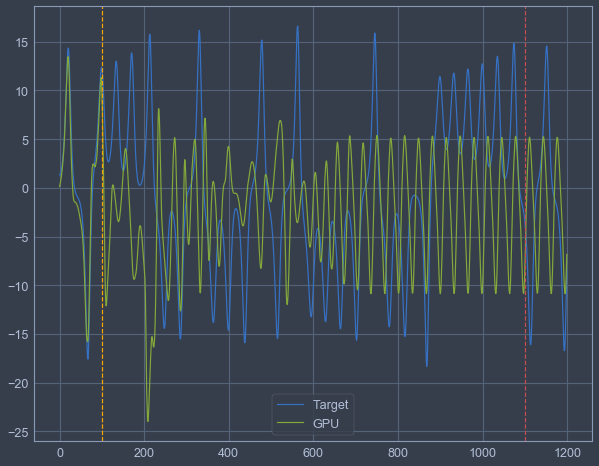

New Best Info a=0.673
 sr=7.761
 amp=0.989
 ri=0.778
 rr=0.127
 nrmse=0.276
 KL 3.682


Iter: 3 #### Diagnostic 0.276   Time 4.696 Best 0.042  KL 3.682 NRMSE 0.276
MSE 1000.000   CM 0.345
Iter: 4 #### Diagnostic 1000.000   Time 6.250 Best 0.042  KL 3.873 NRMSE 1000.000
MSE 0.310   CM 0.481
Iter: 5 #### Diagnostic 0.310   Time 4.596 Best 0.042  KL 8.657 NRMSE 0.310
MSE 1000.000   CM 1000.000
Iter: 6 #### Diagnostic 1000.000   Time 6.597 Best 0.042  KL 1000.000 NRMSE 1000.000
MSE 0.321   CM 0.863
Iter: 7 #### Diagnostic 0.321   Time 4.615 Best 0.042  KL 21.100 NRMSE 0.321
MSE 1000.000   CM 0.171
Iter: 8 #### Diagnostic 1000.000   Time 5.661 Best 0.042  KL 1.227 NRMSE 1000.000
MSE 0.273   CM 0.097
Loss 0.27301965299485315   lc 0.026571476006997982


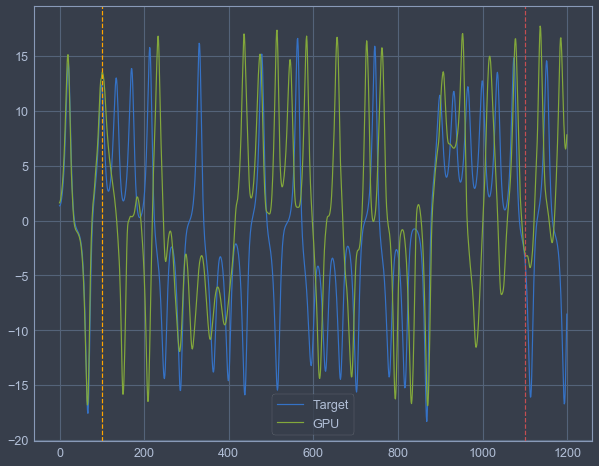

New Best Info a=0.924
 sr=5.421
 amp=0.988
 ri=0.470
 rr=4.118
 nrmse=0.273
 KL 0.565


Iter: 9 #### Diagnostic 0.273   Time 6.819 Best 0.027  KL 0.565 NRMSE 0.273
MSE 1000.000   CM 0.292
Iter: 10 #### Diagnostic 1000.000   Time 5.245 Best 0.027  KL 2.647 NRMSE 1000.000
MSE 0.309   CM 0.063
Loss 0.30879298641438735   lc 0.01951791164912442


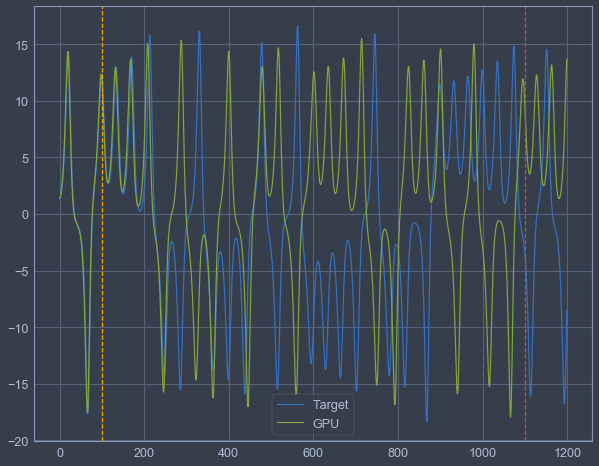

New Best Info a=0.994
 sr=2.562
 amp=0.789
 ri=0.216
 rr=4.756
 nrmse=0.309
 KL 0.709


Iter: 11 #### Diagnostic 0.309   Time 4.841 Best 0.020  KL 0.709 NRMSE 0.309
MSE 0.312   CM 0.867
Iter: 12 #### Diagnostic 0.312   Time 4.738 Best 0.020  KL 17.381 NRMSE 0.312
MSE 1000.000   CM 0.195
Iter: 13 #### Diagnostic 1000.000   Time 5.616 Best 0.020  KL 1.267 NRMSE 1000.000
MSE 0.742   CM 0.031
Iter: 14 #### Diagnostic 0.742   Time 5.521 Best 0.020  KL 0.077 NRMSE 0.742
MSE 1000.000   CM 0.242
Iter: 15 #### Diagnostic 1000.000   Time 6.437 Best 0.020  KL 1.667 NRMSE 1000.000
MSE 1000.000   CM 0.163
Iter: 16 #### Diagnostic 1000.000   Time 6.380 Best 0.020  KL 2.445 NRMSE 1000.000
MSE 1.460   CM 0.371
Iter: 17 #### Diagnostic 1.460   Time 7.764 Best 0.020  KL 1.073 NRMSE 1.460
MSE 1000.000   CM 0.121
Iter: 18 #### Diagnostic 1000.000   Time 5.427 Best 0.020  KL 1.092 NRMSE 1000.000
MSE 0.303   CM 0.475
Iter: 19 #### Diagnostic 0.303   Time 6.100 Best 0.020  KL 11.642 NRMSE 0.303
MSE 0.262   C

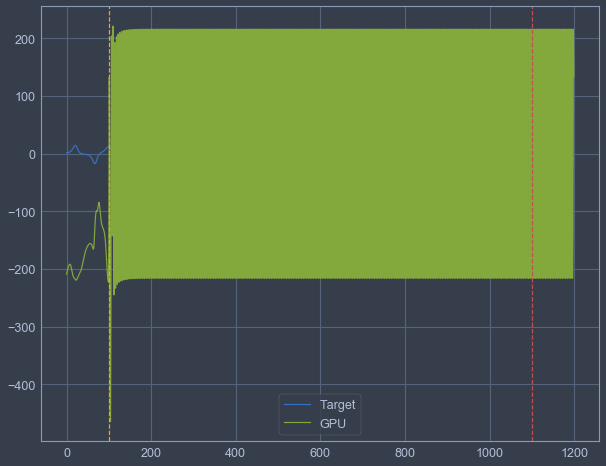

New Best Info a=0.557
 sr=6.466
 amp=0.739
 ri=0.322
 rr=4.560
 nrmse=4.751
 KL 1000.000


Iter: 25 #### Diagnostic 4.751   Time 6.265 Best 0.000  KL 1000.000 NRMSE 4.751
MSE 0.286   CM 0.050
Iter: 26 #### Diagnostic 0.286   Time 4.755 Best 0.000  KL 0.587 NRMSE 0.286
MSE 1000.000   CM 0.241
Iter: 27 #### Diagnostic 1000.000   Time 6.399 Best 0.000  KL 1.826 NRMSE 1000.000
MSE 0.890   CM 0.083
Iter: 28 #### Diagnostic 0.890   Time 6.322 Best 0.000  KL 0.091 NRMSE 0.890
MSE 0.306   CM 0.663
Iter: 29 #### Diagnostic 0.306   Time 5.836 Best 0.000  KL 12.137 NRMSE 0.306
MSE 1257605011613882972635136.000   CM 0.167
Iter: 30 #### Diagnostic 1000.000   Time 5.159 Best 0.000  KL 1.135 NRMSE 1257605011613882972635136.000
MSE 1000.000   CM 0.198
Iter: 31 #### Diagnostic 1000.000   Time 5.546 Best 0.000  KL 2.050 NRMSE 1000.000
MSE 0.282   CM 0.847
Iter: 32 #### Diagnostic 0.282   Time 6.481 Best 0.000  KL 22.439 NRMSE 0.282
MSE 0.302   CM 0.025
Iter: 33 #### Diagnostic 0.302   Time 4.864 Best 0.

MSE 0.299   CM 0.258
Iter: 103 #### Diagnostic 0.299   Time 4.476 Best 0.000  KL 3.511 NRMSE 0.299
MSE 0.282   CM 0.113
Iter: 104 #### Diagnostic 0.282   Time 4.689 Best 0.000  KL 1.412 NRMSE 0.282
MSE 0.297   CM 0.041
Iter: 105 #### Diagnostic 0.297   Time 4.720 Best 0.000  KL 0.601 NRMSE 0.297
MSE 0.308   CM 0.212
Iter: 106 #### Diagnostic 0.308   Time 4.694 Best 0.000  KL 4.044 NRMSE 0.308
MSE 0.304   CM 0.210
Iter: 107 #### Diagnostic 0.304   Time 4.724 Best 0.000  KL 3.398 NRMSE 0.304
MSE 0.290   CM 0.238
Iter: 108 #### Diagnostic 0.290   Time 4.357 Best 0.000  KL 4.663 NRMSE 0.290
MSE 0.316   CM 0.070
Iter: 109 #### Diagnostic 0.316   Time 4.496 Best 0.000  KL 0.269 NRMSE 0.316
MSE 0.286   CM 0.363
Iter: 110 #### Diagnostic 0.286   Time 4.574 Best 0.000  KL 6.409 NRMSE 0.286
MSE 0.354   CM 0.536
Iter: 111 #### Diagnostic 0.354   Time 6.896 Best 0.000  KL 7.011 NRMSE 0.354
MSE 0.270   CM 0.370
Iter: 112 #### Diagnostic 0.270   Time 4.220 Best 0.000  KL 2.822 NRMSE 0.270
MSE 0.292 

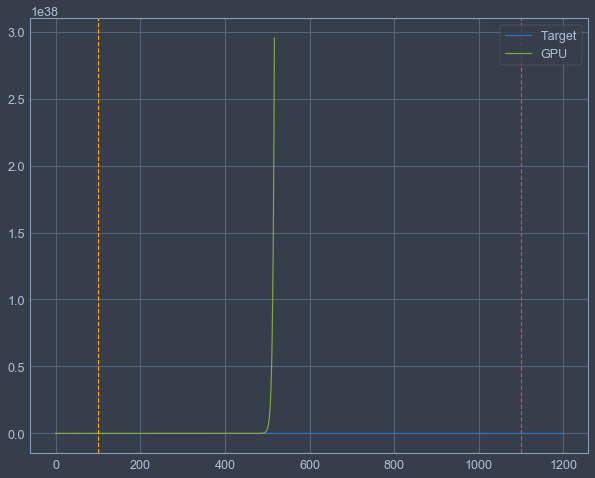

New Best Info a=0.069
 sr=5.318
 amp=0.195
 ri=0.926
 rr=0.527
 nrmse=1000.000
 KL 2.006


Iter: 0 #### Diagnostic 1000.000   Time 5.348 Best 204.682  KL 2.006 NRMSE 1000.000
MSE 1000.000   CM 1000.000
Iter: 1 #### Diagnostic 1000.000   Time 5.066 Best 204.682  KL 1000.000 NRMSE 1000.000
MSE 0.312   CM 0.282
Loss 0.3118072732725055   lc 0.08787312493288925


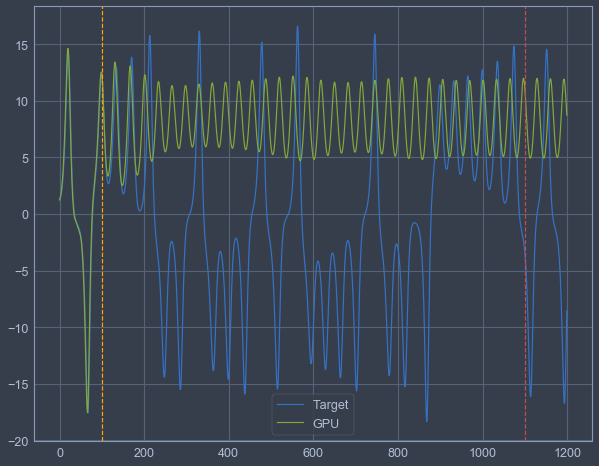

New Best Info a=0.714
 sr=4.144
 amp=0.786
 ri=0.588
 rr=3.684
 nrmse=0.312
 KL 3.978


Iter: 2 #### Diagnostic 0.312   Time 4.807 Best 0.088  KL 3.978 NRMSE 0.312
MSE 0.303   CM 0.034
Loss 0.3028786422631655   lc 0.01017345868860977


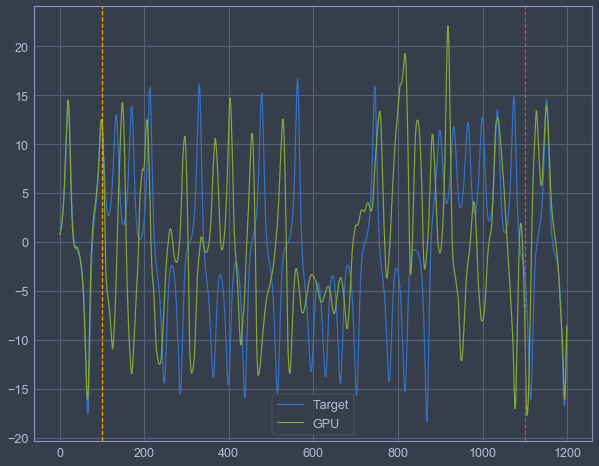

New Best Info a=0.673
 sr=7.761
 amp=0.989
 ri=0.778
 rr=0.127
 nrmse=0.303
 KL 0.210


Iter: 3 #### Diagnostic 0.303   Time 4.800 Best 0.010  KL 0.210 NRMSE 0.303
MSE 1000.000   CM 0.206
Iter: 4 #### Diagnostic 1000.000   Time 6.208 Best 0.010  KL 1.510 NRMSE 1000.000
MSE 0.301   CM 0.649
Iter: 5 #### Diagnostic 0.301   Time 4.535 Best 0.010  KL 8.748 NRMSE 0.301
MSE 1000.000   CM 1000.000
Iter: 6 #### Diagnostic 1000.000   Time 5.450 Best 0.010  KL 1000.000 NRMSE 1000.000
MSE 0.256   CM 0.033
Loss 0.25642345323522014   lc 0.008495083696083818


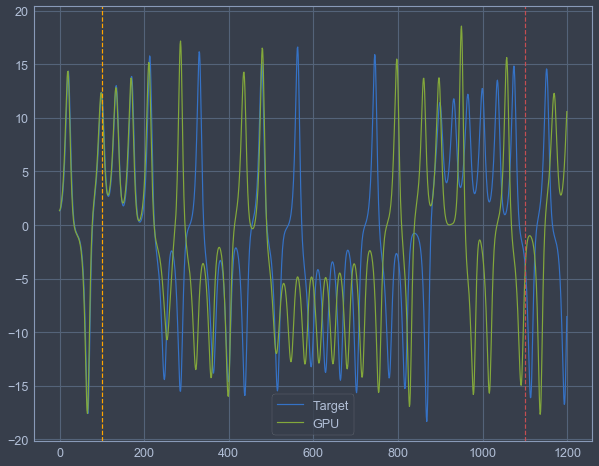

New Best Info a=0.465
 sr=5.432
 amp=0.486
 ri=0.428
 rr=1.992
 nrmse=0.256
 KL 0.206


Iter: 7 #### Diagnostic 0.256   Time 4.701 Best 0.008  KL 0.206 NRMSE 0.256
MSE 1000.000   CM 0.222
Iter: 8 #### Diagnostic 1000.000   Time 6.135 Best 0.008  KL 1.832 NRMSE 1000.000
MSE 0.297   CM 0.552
Iter: 9 #### Diagnostic 0.297   Time 5.319 Best 0.008  KL 12.605 NRMSE 0.297
MSE 1000.000   CM 0.241
Iter: 10 #### Diagnostic 1000.000   Time 5.222 Best 0.008  KL 2.423 NRMSE 1000.000
MSE 0.311   CM 0.735
Iter: 11 #### Diagnostic 0.311   Time 4.199 Best 0.008  KL 9.207 NRMSE 0.311
MSE 0.268   CM 0.202
Iter: 12 #### Diagnostic 0.268   Time 4.460 Best 0.008  KL 1.570 NRMSE 0.268
MSE 1000.000   CM 0.225
Iter: 13 #### Diagnostic 1000.000   Time 6.085 Best 0.008  KL 2.060 NRMSE 1000.000
MSE 1000.000   CM 0.150
Iter: 14 #### Diagnostic 1000.000   Time 7.342 Best 0.008  KL 1.140 NRMSE 1000.000
MSE 1000.000   CM 0.049
Iter: 15 #### Diagnostic 1000.000   Time 5.265 Best 0.008  KL 0.333 NRMSE 1000.000
MSE 1000

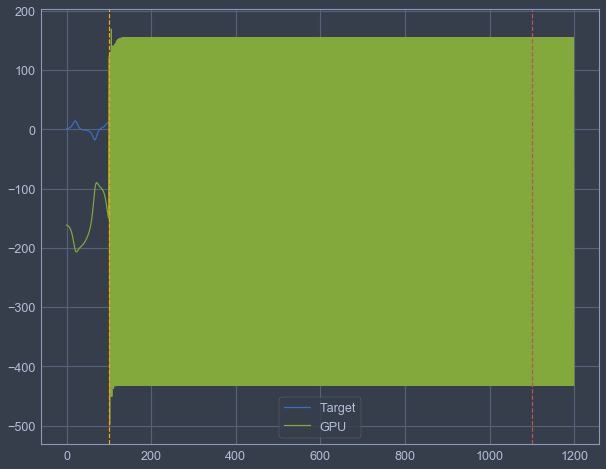

New Best Info a=0.924
 sr=5.924
 amp=0.320
 ri=0.025
 rr=4.308
 nrmse=8.514
 KL 1000.000


Iter: 17 #### Diagnostic 8.514   Time 6.455 Best 0.000  KL 1000.000 NRMSE 8.514
MSE 1000.000   CM 0.201
Iter: 18 #### Diagnostic 1000.000   Time 5.635 Best 0.000  KL 1.266 NRMSE 1000.000
MSE 0.246   CM 0.061
Iter: 19 #### Diagnostic 0.246   Time 5.677 Best 0.000  KL 1.009 NRMSE 0.246
MSE 0.306   CM 0.665
Iter: 20 #### Diagnostic 0.306   Time 4.619 Best 0.000  KL 8.090 NRMSE 0.306
MSE 1000.000   CM 0.115
Iter: 21 #### Diagnostic 1000.000   Time 6.131 Best 0.000  KL 0.365 NRMSE 1000.000
MSE 1000.000   CM 0.141
Iter: 22 #### Diagnostic 1000.000   Time 5.301 Best 0.000  KL 1.359 NRMSE 1000.000
MSE 1.031   CM 0.028
Iter: 23 #### Diagnostic 1.031   Time 5.177 Best 0.000  KL 0.029 NRMSE 1.031
MSE 1.550   CM 0.246
Iter: 24 #### Diagnostic 1.550   Time 5.675 Best 0.000  KL 1.382 NRMSE 1.550
MSE 46.524   CM 0.181
Iter: 25 #### Diagnostic 46.524   Time 5.655 Best 0.000  KL 0.373 NRMSE 46.524
MSE 0.247   CM 

MSE 1000.000   CM 0.231
Iter: 95 #### Diagnostic 1000.000   Time 5.475 Best 0.000  KL 2.535 NRMSE 1000.000
MSE 1000.000   CM 0.232
Iter: 96 #### Diagnostic 1000.000   Time 6.796 Best 0.000  KL 1.883 NRMSE 1000.000
MSE 1000.000   CM 0.089
Iter: 97 #### Diagnostic 1000.000   Time 7.075 Best 0.000  KL 1.146 NRMSE 1000.000
MSE 0.287   CM 0.102
Iter: 98 #### Diagnostic 0.287   Time 5.125 Best 0.000  KL 1.146 NRMSE 0.287
MSE 0.291   CM 0.245
Iter: 99 #### Diagnostic 0.291   Time 5.023 Best 0.000  KL 1.753 NRMSE 0.291
MSE 0.283   CM 0.079
Iter: 100 #### Diagnostic 0.283   Time 4.400 Best 0.000  KL 0.659 NRMSE 0.283
MSE 0.293   CM 0.176
Iter: 101 #### Diagnostic 0.293   Time 4.577 Best 0.000  KL 1.806 NRMSE 0.293
MSE 0.281   CM 0.062
Iter: 102 #### Diagnostic 0.281   Time 4.547 Best 0.000  KL 0.372 NRMSE 0.281
MSE 0.312   CM 0.571
Iter: 103 #### Diagnostic 0.312   Time 4.659 Best 0.000  KL 10.486 NRMSE 0.312
MSE 6.002   CM 0.182
Iter: 104 #### Diagnostic 6.002   Time 6.743 Best 0.000  KL 0.117

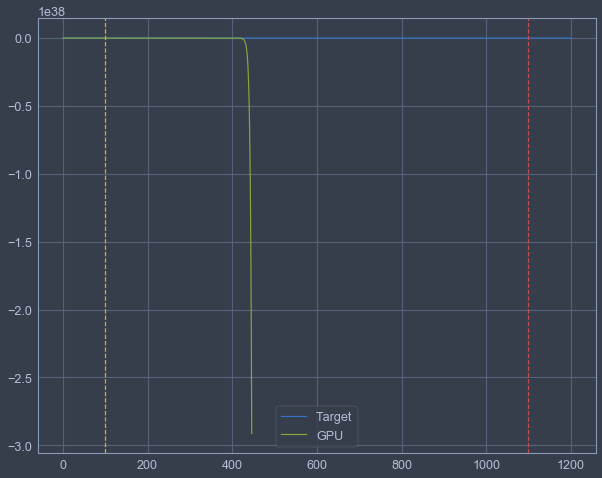

New Best Info a=0.069
 sr=5.318
 amp=0.195
 ri=0.926
 rr=0.527
 nrmse=1000.000
 KL 1.101


Iter: 0 #### Diagnostic 1000.000   Time 5.523 Best 154.330  KL 1.101 NRMSE 1000.000
MSE 1000.000   CM 1000.000
Iter: 1 #### Diagnostic 1000.000   Time 5.574 Best 154.330  KL 1000.000 NRMSE 1000.000
MSE 211931024946664710527484711403520.000   CM 0.116
Loss 1000   lc 116.12882365450083


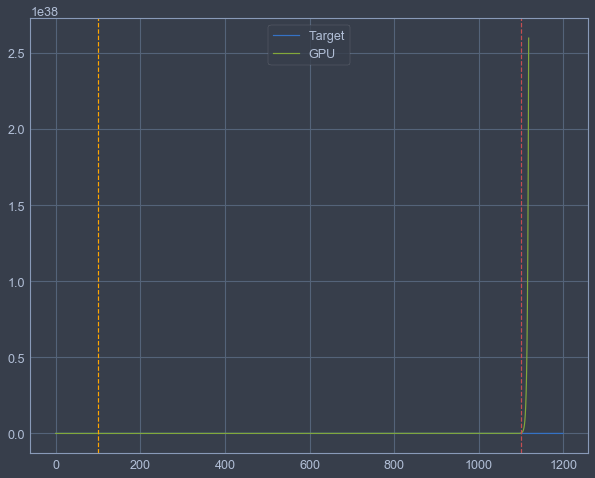

New Best Info a=0.714
 sr=4.144
 amp=0.786
 ri=0.588
 rr=3.684
 nrmse=211931024946664710527484711403520.000
 KL 1.250


Iter: 2 #### Diagnostic 1000.000   Time 4.324 Best 116.129  KL 1.250 NRMSE 211931024946664710527484711403520.000
MSE 0.322   CM 0.069
Loss 0.3215592498831599   lc 0.022251240430769675


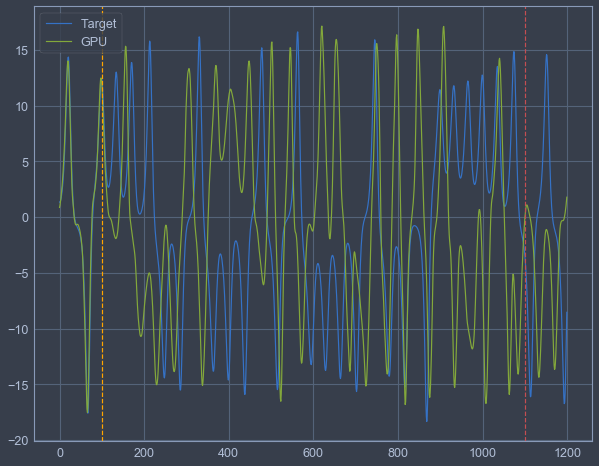

New Best Info a=0.673
 sr=7.761
 amp=0.989
 ri=0.778
 rr=0.127
 nrmse=0.322
 KL 0.656


Iter: 3 #### Diagnostic 0.322   Time 4.643 Best 0.022  KL 0.656 NRMSE 0.322
MSE 1000.000   CM 0.308
Iter: 4 #### Diagnostic 1000.000   Time 6.297 Best 0.022  KL 2.788 NRMSE 1000.000
MSE 0.320   CM 0.858
Iter: 5 #### Diagnostic 0.320   Time 4.163 Best 0.022  KL 18.955 NRMSE 0.320
MSE 1000.000   CM 1000.000
Iter: 6 #### Diagnostic 1000.000   Time 5.271 Best 0.022  KL 1000.000 NRMSE 1000.000
MSE 0.300   CM 0.318
Iter: 7 #### Diagnostic 0.300   Time 4.335 Best 0.022  KL 2.982 NRMSE 0.300
MSE 1000.000   CM 0.314
Iter: 8 #### Diagnostic 1000.000   Time 4.845 Best 0.022  KL 3.047 NRMSE 1000.000
MSE 0.232   CM 0.192
Iter: 9 #### Diagnostic 0.232   Time 4.403 Best 0.022  KL 4.844 NRMSE 0.232
MSE 1000.000   CM 0.289
Iter: 10 #### Diagnostic 1000.000   Time 4.496 Best 0.022  KL 2.963 NRMSE 1000.000
MSE 0.305   CM 0.079
Iter: 11 #### Diagnostic 0.305   Time 4.377 Best 0.022  KL 0.955 NRMSE 0.305
MSE 0.268   CM 

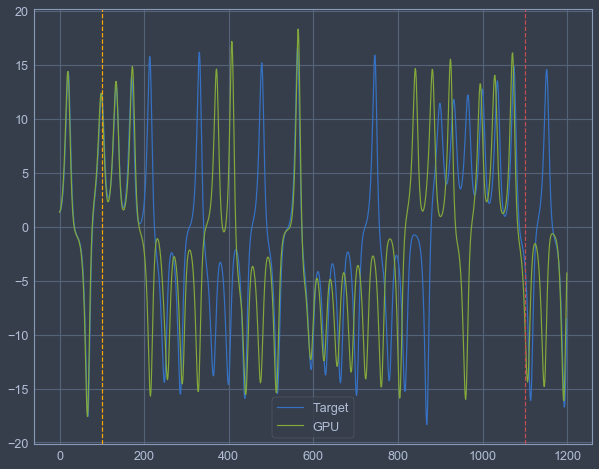

New Best Info a=0.390
 sr=3.427
 amp=0.549
 ri=0.396
 rr=2.047
 nrmse=0.240
 KL 0.248


Iter: 16 #### Diagnostic 0.240   Time 6.729 Best 0.007  KL 0.248 NRMSE 0.240
MSE 5.795   CM 0.000
Loss 5.794673941099414   lc 0.0


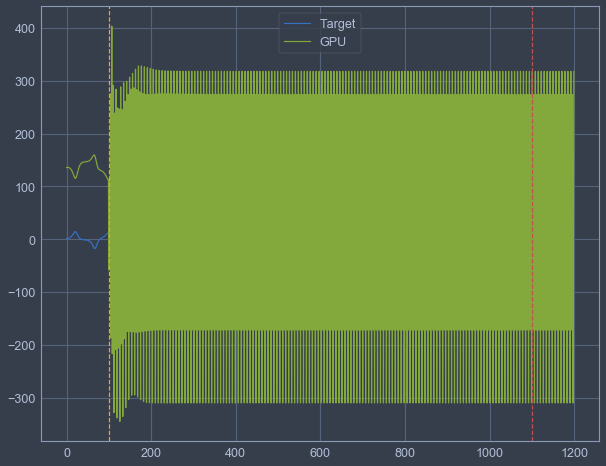

New Best Info a=0.924
 sr=5.924
 amp=0.320
 ri=0.025
 rr=4.308
 nrmse=5.795
 KL 1000.000


Iter: 17 #### Diagnostic 5.795   Time 5.093 Best 0.000  KL 1000.000 NRMSE 5.795
MSE 1000.000   CM 0.359
Iter: 18 #### Diagnostic 1000.000   Time 4.527 Best 0.000  KL 3.176 NRMSE 1000.000
MSE 0.285   CM 0.078
Iter: 19 #### Diagnostic 0.285   Time 6.384 Best 0.000  KL 0.761 NRMSE 0.285
MSE 0.280   CM 0.439
Iter: 20 #### Diagnostic 0.280   Time 4.334 Best 0.000  KL 9.590 NRMSE 0.280
MSE 1000.000   CM 0.094
Iter: 21 #### Diagnostic 1000.000   Time 4.855 Best 0.000  KL 0.122 NRMSE 1000.000
MSE 1000.000   CM 0.339
Iter: 22 #### Diagnostic 1000.000   Time 5.287 Best 0.000  KL 3.342 NRMSE 1000.000
MSE 0.555   CM 0.324
Iter: 23 #### Diagnostic 0.555   Time 5.587 Best 0.000  KL 4.287 NRMSE 0.555
MSE 1000.000   CM 0.262
Iter: 24 #### Diagnostic 1000.000   Time 5.429 Best 0.000  KL 2.756 NRMSE 1000.000
MSE 36.040   CM 0.125
Iter: 25 #### Diagnostic 36.040   Time 5.783 Best 0.000  KL 0.413 NRMSE 36.040
MSE 10

MSE 0.339   CM 0.642
Iter: 94 #### Diagnostic 0.339   Time 6.302 Best 0.000  KL 10.825 NRMSE 0.339
MSE 0.729   CM 0.498
Iter: 95 #### Diagnostic 0.729   Time 5.282 Best 0.000  KL 9.367 NRMSE 0.729
MSE 1000.000   CM 0.140
Iter: 96 #### Diagnostic 1000.000   Time 4.532 Best 0.000  KL 0.852 NRMSE 1000.000
MSE 1000.000   CM 0.208
Iter: 97 #### Diagnostic 1000.000   Time 6.508 Best 0.000  KL 1.709 NRMSE 1000.000
MSE 1000.000   CM 0.260
Iter: 98 #### Diagnostic 1000.000   Time 5.124 Best 0.000  KL 3.396 NRMSE 1000.000
MSE 0.310   CM 0.739
Iter: 99 #### Diagnostic 0.310   Time 4.777 Best 0.000  KL 13.157 NRMSE 0.310
MSE 0.260   CM 0.046
Iter: 100 #### Diagnostic 0.260   Time 4.054 Best 0.000  KL 0.578 NRMSE 0.260
MSE 2.355   CM 0.205
Iter: 101 #### Diagnostic 2.355   Time 5.773 Best 0.000  KL 1.421 NRMSE 2.355
MSE 1.895   CM 0.309
Iter: 102 #### Diagnostic 1.895   Time 4.801 Best 0.000  KL 2.771 NRMSE 1.895
MSE 1000.000   CM 0.118
Iter: 103 #### Diagnostic 1000.000   Time 6.304 Best 0.000  KL

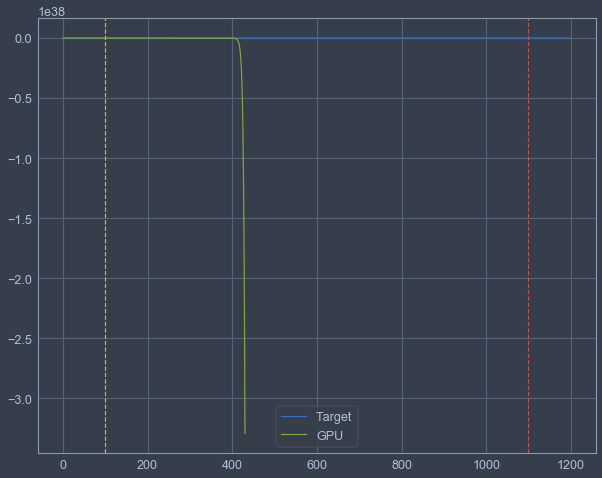

New Best Info a=0.069
 sr=5.318
 amp=0.195
 ri=0.926
 rr=0.527
 nrmse=1000.000
 KL 3.523


Iter: 0 #### Diagnostic 1000.000   Time 5.451 Best 359.673  KL 3.523 NRMSE 1000.000
MSE 1000.000   CM 1000.000
Iter: 1 #### Diagnostic 1000.000   Time 5.260 Best 359.673  KL 1000.000 NRMSE 1000.000
MSE 0.250   CM 0.042
Loss 0.25005850915311884   lc 0.01039788118948074


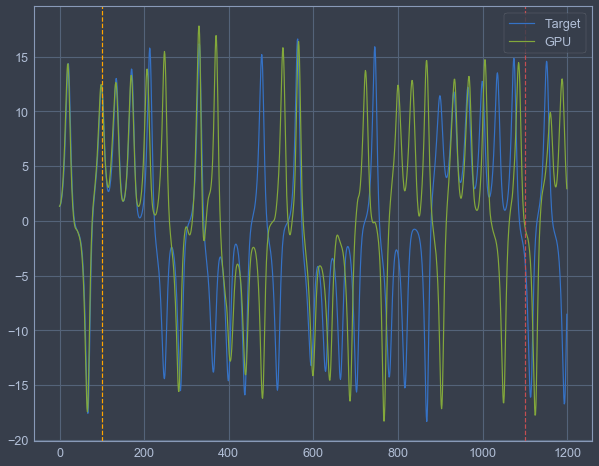

New Best Info a=0.714
 sr=4.144
 amp=0.786
 ri=0.588
 rr=3.684
 nrmse=0.250
 KL 0.441


Iter: 2 #### Diagnostic 0.250   Time 4.707 Best 0.010  KL 0.441 NRMSE 0.250
MSE 0.298   CM 0.518
Iter: 3 #### Diagnostic 0.298   Time 4.717 Best 0.010  KL 7.493 NRMSE 0.298
MSE 1000.000   CM 0.171
Iter: 4 #### Diagnostic 1000.000   Time 6.245 Best 0.010  KL 1.834 NRMSE 1000.000
MSE 0.275   CM 0.810
Iter: 5 #### Diagnostic 0.275   Time 4.547 Best 0.010  KL 16.660 NRMSE 0.275
MSE 1000.000   CM 1000.000
Iter: 6 #### Diagnostic 1000.000   Time 4.507 Best 0.010  KL 1000.000 NRMSE 1000.000
MSE 0.272   CM 0.159
Iter: 7 #### Diagnostic 0.272   Time 4.266 Best 0.010  KL 1.511 NRMSE 0.272
MSE 1000.000   CM 0.180
Iter: 8 #### Diagnostic 1000.000   Time 5.675 Best 0.010  KL 1.492 NRMSE 1000.000
MSE 1000.000   CM 0.127
Iter: 9 #### Diagnostic 1000.000   Time 4.494 Best 0.010  KL 0.037 NRMSE 1000.000
MSE 1000.000   CM 0.306
Iter: 10 #### Diagnostic 1000.000   Time 4.783 Best 0.010  KL 3.487 NRMSE 1000.000
MSE 0.2

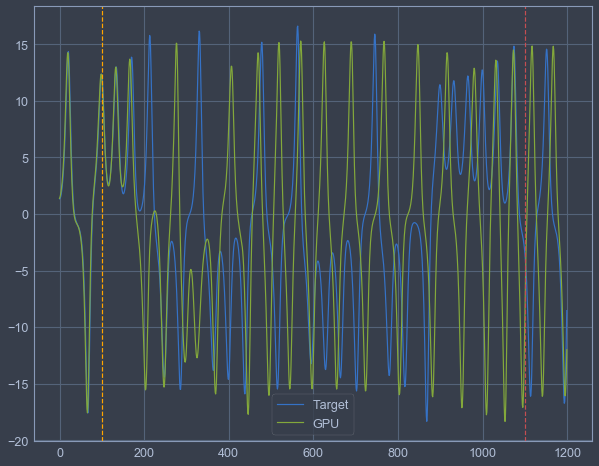

New Best Info a=0.335
 sr=4.015
 amp=0.721
 ri=0.373
 rr=0.794
 nrmse=0.281
 KL 1000.000


Iter: 12 #### Diagnostic 0.281   Time 4.364 Best 0.009  KL 1000.000 NRMSE 0.281
MSE 0.254   CM 0.137
Iter: 13 #### Diagnostic 0.254   Time 5.839 Best 0.009  KL 1.845 NRMSE 0.254
MSE 0.279   CM 0.076
Iter: 14 #### Diagnostic 0.279   Time 5.786 Best 0.009  KL 0.473 NRMSE 0.279
MSE 1000.000   CM 0.178
Iter: 15 #### Diagnostic 1000.000   Time 5.193 Best 0.009  KL 1.321 NRMSE 1000.000
MSE 1000.000   CM 0.185
Iter: 16 #### Diagnostic 1000.000   Time 4.322 Best 0.009  KL 1.946 NRMSE 1000.000
MSE 7.814   CM 0.142
Iter: 17 #### Diagnostic 7.814   Time 5.118 Best 0.009  KL 1.679 NRMSE 7.814
MSE 1000.000   CM 0.269
Iter: 18 #### Diagnostic 1000.000   Time 4.913 Best 0.009  KL 2.201 NRMSE 1000.000
MSE 0.317   CM 0.183
Iter: 19 #### Diagnostic 0.317   Time 4.745 Best 0.009  KL 2.116 NRMSE 0.317
MSE 0.289   CM 0.070
Iter: 20 #### Diagnostic 0.289   Time 3.945 Best 0.009  KL 0.557 NRMSE 0.289
MSE 1000.000   CM 

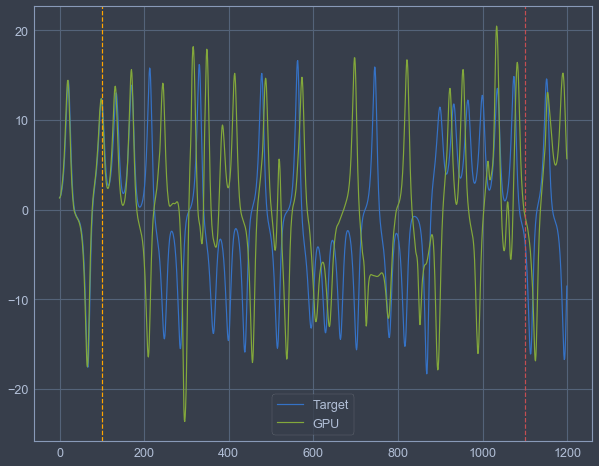

New Best Info a=0.926
 sr=2.795
 amp=0.900
 ri=0.507
 rr=4.912
 nrmse=0.282
 KL 0.392


Iter: 51 #### Diagnostic 0.282   Time 4.665 Best 0.009  KL 0.392 NRMSE 0.282
MSE 1000.000   CM 0.064
Iter: 52 #### Diagnostic 1000.000   Time 5.912 Best 0.009  KL 0.365 NRMSE 1000.000
MSE 0.282   CM 0.683
Iter: 53 #### Diagnostic 0.282   Time 4.309 Best 0.009  KL 12.715 NRMSE 0.282
MSE 1000.000   CM 0.242
Iter: 54 #### Diagnostic 1000.000   Time 6.444 Best 0.009  KL 1.643 NRMSE 1000.000
MSE 0.305   CM 0.097
Iter: 55 #### Diagnostic 0.305   Time 5.027 Best 0.009  KL 1.077 NRMSE 0.305
MSE 0.272   CM 0.046
Iter: 56 #### Diagnostic 0.272   Time 4.167 Best 0.009  KL 0.412 NRMSE 0.272
MSE 1000.000   CM 0.243
Iter: 57 #### Diagnostic 1000.000   Time 6.222 Best 0.009  KL 1.460 NRMSE 1000.000
MSE 1000.000   CM 0.184
Iter: 58 #### Diagnostic 1000.000   Time 4.693 Best 0.009  KL 1.137 NRMSE 1000.000
MSE 1000.000   CM 0.087
Iter: 59 #### Diagnostic 1000.000   Time 5.101 Best 0.009  KL 0.850 NRMSE 1000.000
MSE 1

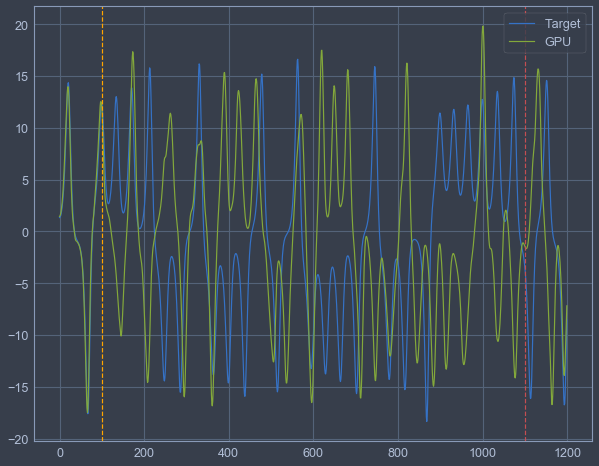

New Best Info a=0.676
 sr=6.432
 amp=0.712
 ri=0.900
 rr=1.437
 nrmse=0.302
 KL 0.097


Iter: 72 #### Diagnostic 0.302   Time 4.406 Best 0.006  KL 0.097 NRMSE 0.302
MSE 1000.000   CM 0.325
Iter: 73 #### Diagnostic 1000.000   Time 5.048 Best 0.006  KL 2.604 NRMSE 1000.000
MSE 1000.000   CM 0.275
Iter: 74 #### Diagnostic 1000.000   Time 5.142 Best 0.006  KL 2.067 NRMSE 1000.000
MSE 0.244   CM 0.297
Iter: 75 #### Diagnostic 0.244   Time 4.843 Best 0.006  KL 7.103 NRMSE 0.244
MSE 1000.000   CM 0.209
Iter: 76 #### Diagnostic 1000.000   Time 4.730 Best 0.006  KL 1.599 NRMSE 1000.000
MSE 1000.000   CM 0.235
Iter: 77 #### Diagnostic 1000.000   Time 6.257 Best 0.006  KL 1.613 NRMSE 1000.000
MSE 1000.000   CM 0.174
Iter: 78 #### Diagnostic 1000.000   Time 5.536 Best 0.006  KL 1.394 NRMSE 1000.000
MSE 1000.000   CM 0.182
Iter: 79 #### Diagnostic 1000.000   Time 4.580 Best 0.006  KL 1.424 NRMSE 1000.000
MSE 1000.000   CM 0.276
Iter: 80 #### Diagnostic 1000.000   Time 5.279 Best 0.006  KL 2.277 NRM

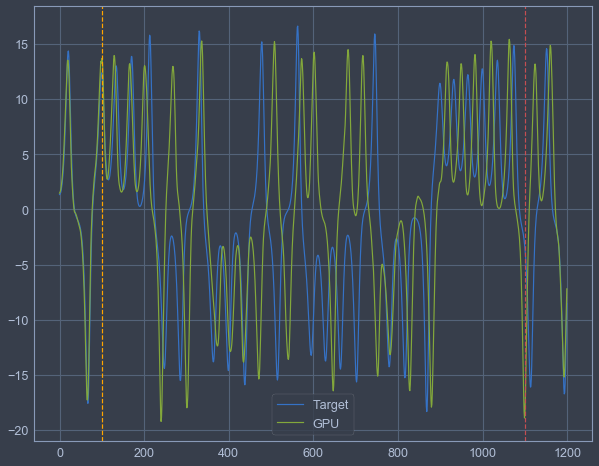

New Best Info a=0.683
 sr=6.429
 amp=0.904
 ri=0.861
 rr=1.958
 nrmse=0.247
 KL 0.144


Iter: 111 #### Diagnostic 0.247   Time 4.457 Best 0.005  KL 0.144 NRMSE 0.247
MSE 0.306   CM 0.165
Iter: 112 #### Diagnostic 0.306   Time 4.288 Best 0.005  KL 1.757 NRMSE 0.306
MSE 0.249   CM 0.039
Iter: 113 #### Diagnostic 0.249   Time 4.307 Best 0.005  KL 0.287 NRMSE 0.249
MSE 0.320   CM 0.563
Iter: 114 #### Diagnostic 0.320   Time 4.539 Best 0.005  KL 7.675 NRMSE 0.320
MSE 0.306   CM 0.065
Iter: 115 #### Diagnostic 0.306   Time 4.351 Best 0.005  KL 0.303 NRMSE 0.306
MSE 0.327   CM 0.678
Iter: 116 #### Diagnostic 0.327   Time 4.114 Best 0.005  KL 8.247 NRMSE 0.327
MSE 0.233   CM 0.111
Iter: 117 #### Diagnostic 0.233   Time 4.297 Best 0.005  KL 0.784 NRMSE 0.233
MSE 0.298   CM 0.045
Iter: 118 #### Diagnostic 0.298   Time 4.008 Best 0.005  KL 0.652 NRMSE 0.298
MSE 0.339   CM 0.178
Iter: 119 #### Diagnostic 0.339   Time 4.456 Best 0.005  KL 2.651 NRMSE 0.339
MSE 0.265   CM 0.099
Iter: 120 #### Diagno

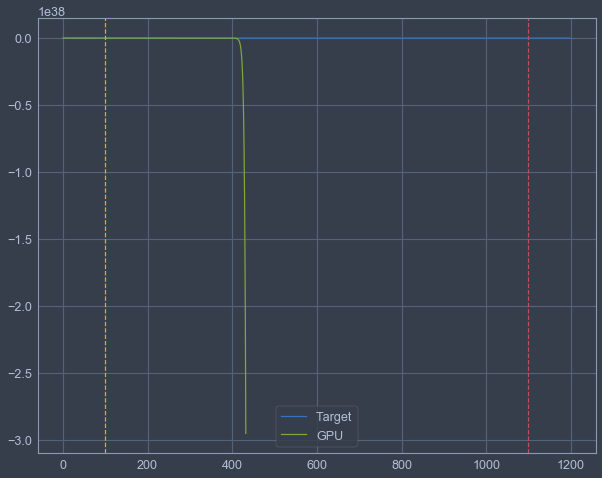

New Best Info a=0.069
 sr=5.318
 amp=0.195
 ri=0.926
 rr=0.527
 nrmse=1000.000
 KL 2.224


Iter: 0 #### Diagnostic 1000.000   Time 6.105 Best 289.203  KL 2.224 NRMSE 1000.000
MSE 1000.000   CM 1000.000
Iter: 1 #### Diagnostic 1000.000   Time 4.831 Best 289.203  KL 1000.000 NRMSE 1000.000
MSE 0.311   CM 0.840
Loss 0.31050994861250464   lc 0.2608695644621373


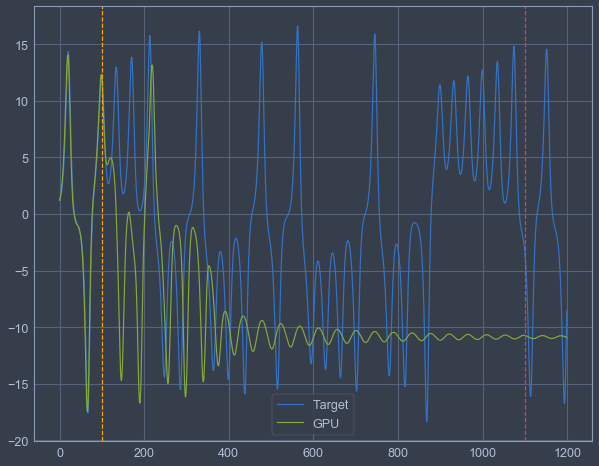

New Best Info a=0.714
 sr=4.144
 amp=0.786
 ri=0.588
 rr=3.684
 nrmse=0.311
 KL 18.093


Iter: 2 #### Diagnostic 0.311   Time 4.328 Best 0.261  KL 18.093 NRMSE 0.311
MSE 0.280   CM 0.865
Loss 0.27984433763689787   lc 0.24212394984149355


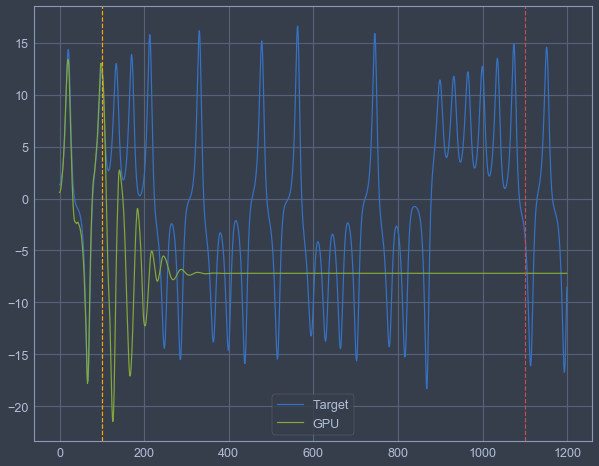

New Best Info a=0.673
 sr=7.761
 amp=0.989
 ri=0.778
 rr=0.127
 nrmse=0.280
 KL 23.431


Iter: 3 #### Diagnostic 0.280   Time 4.866 Best 0.242  KL 23.431 NRMSE 0.280
MSE 1000.000   CM 0.192
Iter: 4 #### Diagnostic 1000.000   Time 5.088 Best 0.242  KL 2.076 NRMSE 1000.000
MSE 0.298   CM 0.142
Loss 0.2982065350426323   lc 0.04246895197267467


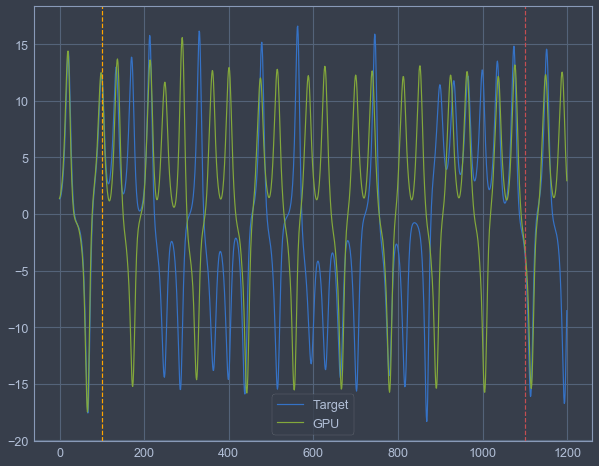

New Best Info a=0.156
 sr=6.199
 amp=0.484
 ri=0.784
 rr=0.225
 nrmse=0.298
 KL 1.738


Iter: 5 #### Diagnostic 0.298   Time 4.156 Best 0.042  KL 1.738 NRMSE 0.298
MSE 1000.000   CM 1000.000
Iter: 6 #### Diagnostic 1000.000   Time 5.528 Best 0.042  KL 1000.000 NRMSE 1000.000
MSE 0.257   CM 0.032
Loss 0.25666793099551793   lc 0.008223809223126242


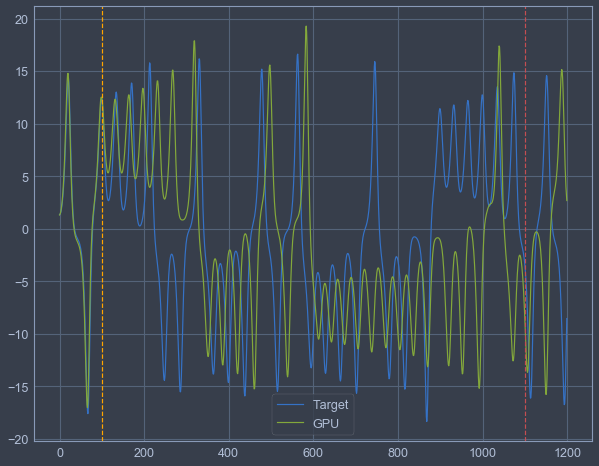

New Best Info a=0.465
 sr=5.432
 amp=0.486
 ri=0.428
 rr=1.992
 nrmse=0.257
 KL 0.238


Iter: 7 #### Diagnostic 0.257   Time 4.244 Best 0.008  KL 0.238 NRMSE 0.257
MSE 1000.000   CM 0.253
Iter: 8 #### Diagnostic 1000.000   Time 5.328 Best 0.008  KL 2.030 NRMSE 1000.000
MSE 0.245   CM 0.258
Iter: 9 #### Diagnostic 0.245   Time 4.029 Best 0.008  KL 8.563 NRMSE 0.245
MSE 1000.000   CM 0.313
Iter: 10 #### Diagnostic 1000.000   Time 5.312 Best 0.008  KL 3.219 NRMSE 1000.000
MSE 0.284   CM 0.768
Iter: 11 #### Diagnostic 0.284   Time 4.099 Best 0.008  KL 12.212 NRMSE 0.284
MSE 0.310   CM 0.234
Iter: 12 #### Diagnostic 0.310   Time 4.300 Best 0.008  KL 2.331 NRMSE 0.310
MSE 1000.000   CM 0.190
Iter: 13 #### Diagnostic 1000.000   Time 6.320 Best 0.008  KL 1.289 NRMSE 1000.000
MSE 0.281   CM 0.036
Iter: 14 #### Diagnostic 0.281   Time 4.780 Best 0.008  KL 0.219 NRMSE 0.281
MSE 1000.000   CM 0.125
Iter: 15 #### Diagnostic 1000.000   Time 4.980 Best 0.008  KL 0.629 NRMSE 1000.000
MSE 1000.000   CM

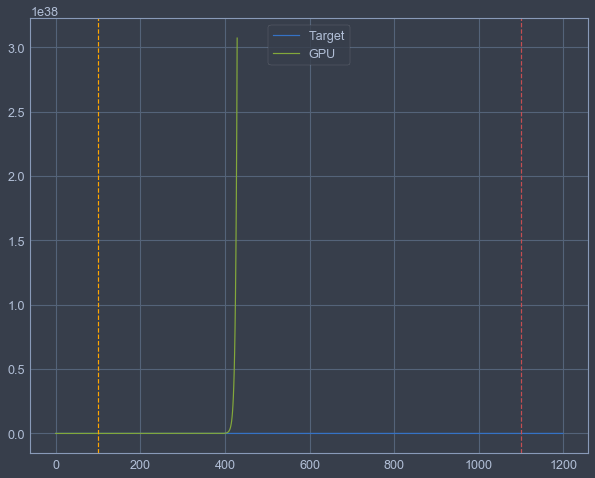

New Best Info a=0.897
 sr=5.917
 amp=0.769
 ri=0.325
 rr=0.797
 nrmse=1000.000
 KL 1000.000


Iter: 44 #### Diagnostic 1000.000   Time 5.572 Best 0.000  KL 1000.000 NRMSE 1000.000
MSE 1000.000   CM 0.027
Iter: 45 #### Diagnostic 1000.000   Time 4.484 Best 0.000  KL 0.357 NRMSE 1000.000
MSE 1000.000   CM 0.393
Iter: 46 #### Diagnostic 1000.000   Time 4.436 Best 0.000  KL 5.373 NRMSE 1000.000
MSE 1000.000   CM 0.239
Iter: 47 #### Diagnostic 1000.000   Time 4.371 Best 0.000  KL 1.881 NRMSE 1000.000
MSE 1000.000   CM 0.094
Iter: 48 #### Diagnostic 1000.000   Time 5.198 Best 0.000  KL 0.835 NRMSE 1000.000
MSE 80.100   CM 1000.000
Iter: 49 #### Diagnostic 80.100   Time 4.706 Best 0.000  KL 1000.000 NRMSE 80.100
MSE 0.291   CM 0.121
Iter: 50 #### Diagnostic 0.291   Time 4.402 Best 0.000  KL 1.558 NRMSE 0.291
MSE 45.755   CM 0.095
Iter: 51 #### Diagnostic 45.755   Time 3.885 Best 0.000  KL 1.214 NRMSE 45.755
MSE 1000.000   CM 0.111
Iter: 52 #### Diagnostic 1000.000   Time 4.811 Best 0.000  KL 

MSE 1000.000   CM 0.079
Iter: 122 #### Diagnostic 1000.000   Time 4.178 Best 0.000  KL 0.013 NRMSE 1000.000
MSE 0.302   CM 0.625
Iter: 123 #### Diagnostic 0.302   Time 4.226 Best 0.000  KL 12.140 NRMSE 0.302
MSE 0.388   CM 0.135
Iter: 124 #### Diagnostic 0.388   Time 4.371 Best 0.000  KL 0.989 NRMSE 0.388
MSE 0.307   CM 0.617
Iter: 125 #### Diagnostic 0.307   Time 4.078 Best 0.000  KL 15.269 NRMSE 0.307
MSE 1.360   CM 0.173
Iter: 126 #### Diagnostic 1.360   Time 5.304 Best 0.000  KL 0.915 NRMSE 1.360
MSE 0.274   CM 0.068
Iter: 127 #### Diagnostic 0.274   Time 4.528 Best 0.000  KL 0.766 NRMSE 0.274
MSE 0.262   CM 0.434
Iter: 128 #### Diagnostic 0.262   Time 4.181 Best 0.000  KL 7.072 NRMSE 0.262
MSE 0.281   CM 0.831
Iter: 129 #### Diagnostic 0.281   Time 4.389 Best 0.000  KL 21.418 NRMSE 0.281
MSE 0.301   CM 0.042
Iter: 130 #### Diagnostic 0.301   Time 4.074 Best 0.000  KL 0.030 NRMSE 0.301
MSE 0.272   CM 0.297
Iter: 131 #### Diagnostic 0.272   Time 4.152 Best 0.000  KL 6.679 NRMSE 0.27

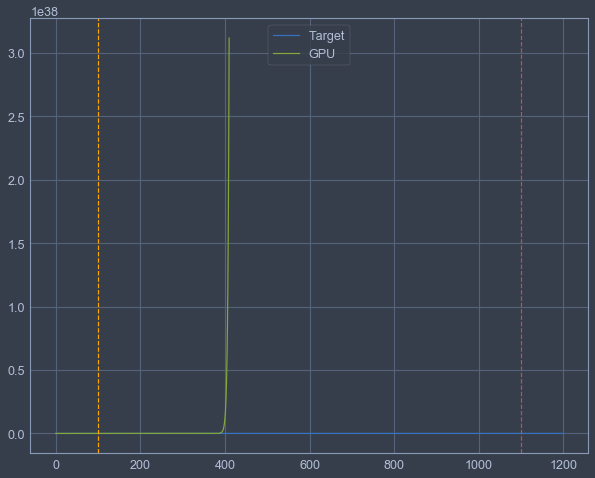

New Best Info a=0.069
 sr=5.318
 amp=0.195
 ri=0.926
 rr=0.527
 nrmse=1000.000
 KL 0.810


Iter: 0 #### Diagnostic 1000.000   Time 5.000 Best 140.222  KL 0.810 NRMSE 1000.000
MSE 1000.000   CM 1000.000
Iter: 1 #### Diagnostic 1000.000   Time 5.717 Best 140.222  KL 1000.000 NRMSE 1000.000
MSE 0.272   CM 0.696
Loss 0.272373749365396   lc 0.1894425053536361


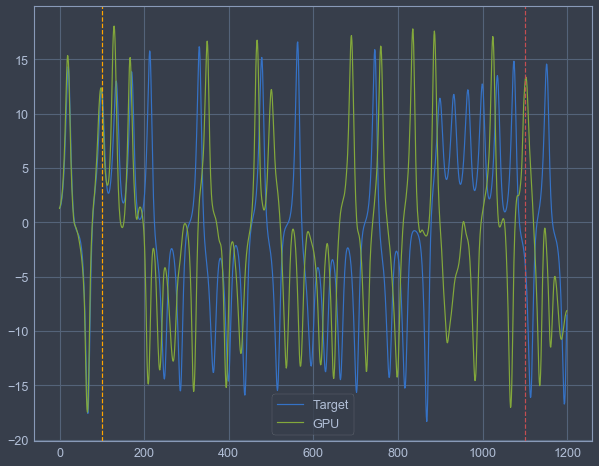

New Best Info a=0.714
 sr=4.144
 amp=0.786
 ri=0.588
 rr=3.684
 nrmse=0.272
 KL 9.453


Iter: 2 #### Diagnostic 0.272   Time 4.323 Best 0.189  KL 9.453 NRMSE 0.272
MSE 0.233   CM 0.405
Loss 0.2328606850113303   lc 0.0943680321720044


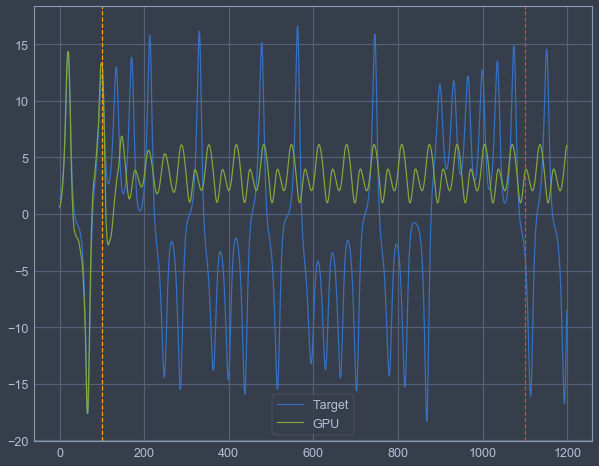

New Best Info a=0.673
 sr=7.761
 amp=0.989
 ri=0.778
 rr=0.127
 nrmse=0.233
 KL 9.671


Iter: 3 #### Diagnostic 0.233   Time 4.228 Best 0.094  KL 9.671 NRMSE 0.233
MSE 1000.000   CM 0.217
Iter: 4 #### Diagnostic 1000.000   Time 4.834 Best 0.094  KL 2.348 NRMSE 1000.000
MSE 0.268   CM 0.800
Iter: 5 #### Diagnostic 0.268   Time 4.049 Best 0.094  KL 13.969 NRMSE 0.268
MSE 1000.000   CM 1000.000
Iter: 6 #### Diagnostic 1000.000   Time 4.680 Best 0.094  KL 1000.000 NRMSE 1000.000
MSE 0.293   CM 0.200
Loss 0.2929745163748935   lc 0.058740797843988335


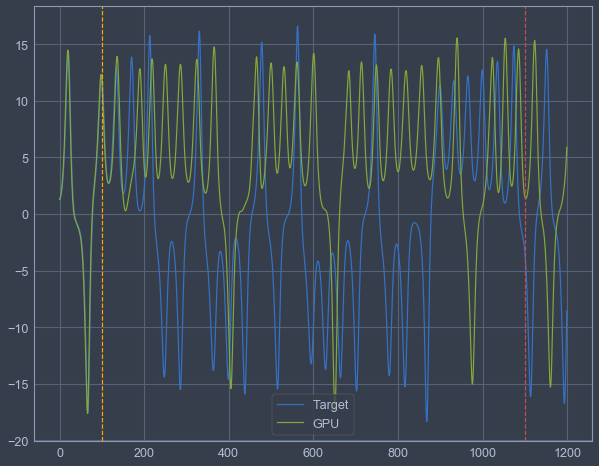

New Best Info a=0.465
 sr=5.432
 amp=0.486
 ri=0.428
 rr=1.992
 nrmse=0.293
 KL 2.425


Iter: 7 #### Diagnostic 0.293   Time 4.657 Best 0.059  KL 2.425 NRMSE 0.293
MSE 1000.000   CM 0.291
Iter: 8 #### Diagnostic 1000.000   Time 4.738 Best 0.059  KL 2.452 NRMSE 1000.000
MSE 0.264   CM 0.373
Iter: 9 #### Diagnostic 0.264   Time 5.323 Best 0.059  KL 5.385 NRMSE 0.264
MSE 1000.000   CM 0.238
Iter: 10 #### Diagnostic 1000.000   Time 4.870 Best 0.059  KL 2.135 NRMSE 1000.000
MSE 0.310   CM 0.139
Loss 0.309773049250864   lc 0.04314586974100065


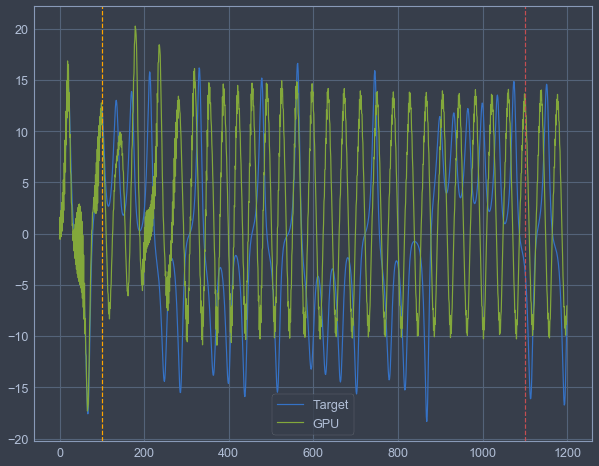

New Best Info a=0.994
 sr=2.562
 amp=0.789
 ri=0.216
 rr=4.756
 nrmse=0.310
 KL 0.594


Iter: 11 #### Diagnostic 0.310   Time 4.041 Best 0.043  KL 0.594 NRMSE 0.310
MSE 0.285   CM 0.036
Loss 0.2847925865243561   lc 0.010252506018982326


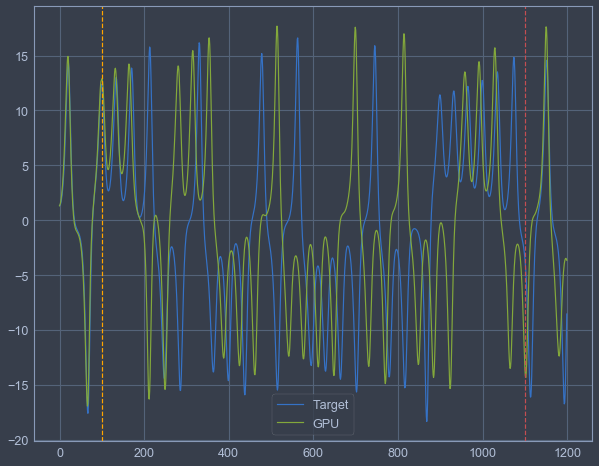

New Best Info a=0.335
 sr=4.015
 amp=0.721
 ri=0.373
 rr=0.794
 nrmse=0.285
 KL 0.645


Iter: 12 #### Diagnostic 0.285   Time 4.233 Best 0.010  KL 0.645 NRMSE 0.285
MSE 1000.000   CM 0.112
Iter: 13 #### Diagnostic 1000.000   Time 4.793 Best 0.010  KL 0.409 NRMSE 1000.000
MSE 0.344   CM 0.197
Iter: 14 #### Diagnostic 0.344   Time 5.186 Best 0.010  KL 0.804 NRMSE 0.344
MSE 1000.000   CM 0.040
Iter: 15 #### Diagnostic 1000.000   Time 5.481 Best 0.010  KL 0.063 NRMSE 1000.000
MSE 1000.000   CM 0.090
Iter: 16 #### Diagnostic 1000.000   Time 6.107 Best 0.010  KL 0.981 NRMSE 1000.000
MSE 1.688   CM 0.255
Iter: 17 #### Diagnostic 1.688   Time 5.162 Best 0.010  KL 0.198 NRMSE 1.688
MSE 1000.000   CM 0.270
Iter: 18 #### Diagnostic 1000.000   Time 5.613 Best 0.010  KL 2.532 NRMSE 1000.000
MSE 0.265   CM 0.055
Iter: 19 #### Diagnostic 0.265   Time 4.462 Best 0.010  KL 0.868 NRMSE 0.265
MSE 0.241   CM 0.028
Loss 0.24052353470372656   lc 0.006759127428313067


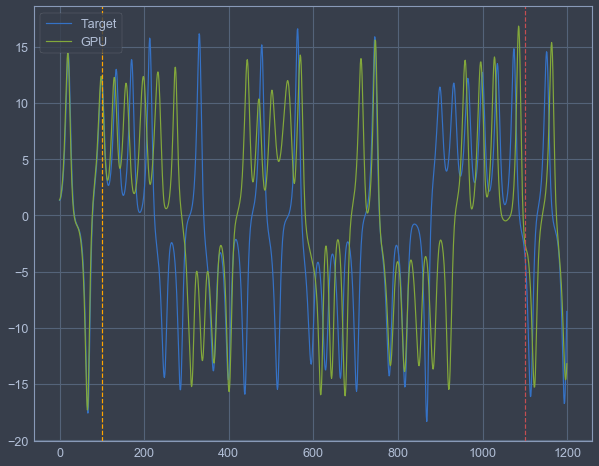

New Best Info a=0.256
 sr=5.801
 amp=0.913
 ri=0.877
 rr=4.039
 nrmse=0.241
 KL 0.078


Iter: 20 #### Diagnostic 0.241   Time 5.878 Best 0.007  KL 0.078 NRMSE 0.241
MSE 1000.000   CM 0.059
Iter: 21 #### Diagnostic 1000.000   Time 4.855 Best 0.007  KL 0.309 NRMSE 1000.000
MSE 1000.000   CM 0.351
Iter: 22 #### Diagnostic 1000.000   Time 5.033 Best 0.007  KL 2.497 NRMSE 1000.000
MSE 0.274   CM 0.022
Loss 0.27373947981418606   lc 0.005989878749572713


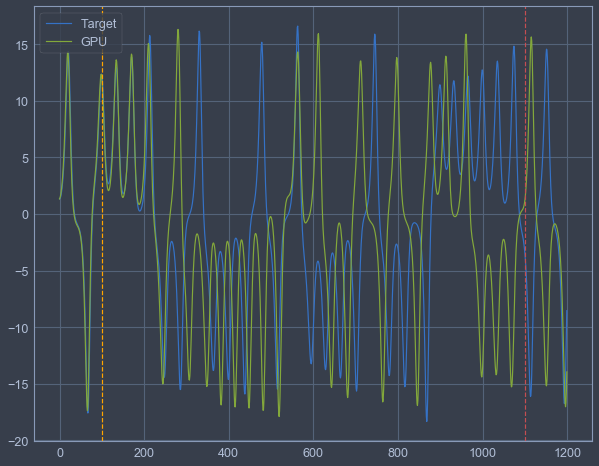

New Best Info a=0.305
 sr=5.580
 amp=0.781
 ri=0.460
 rr=3.231
 nrmse=0.274
 KL 0.277


Iter: 23 #### Diagnostic 0.274   Time 5.101 Best 0.006  KL 0.277 NRMSE 0.274
MSE 1000.000   CM 0.153
Iter: 24 #### Diagnostic 1000.000   Time 4.919 Best 0.006  KL 1.034 NRMSE 1000.000
MSE 0.293   CM 0.084
Iter: 25 #### Diagnostic 0.293   Time 4.518 Best 0.006  KL 1.303 NRMSE 0.293
MSE 0.305   CM 0.521
Iter: 26 #### Diagnostic 0.305   Time 4.439 Best 0.006  KL 5.713 NRMSE 0.305
MSE 1000.000   CM 0.178
Iter: 27 #### Diagnostic 1000.000   Time 4.765 Best 0.006  KL 1.305 NRMSE 1000.000
MSE 1.169   CM 0.222
Iter: 28 #### Diagnostic 1.169   Time 4.770 Best 0.006  KL 1.027 NRMSE 1.169
MSE 0.330   CM 0.300
Iter: 29 #### Diagnostic 0.330   Time 4.911 Best 0.006  KL 4.674 NRMSE 0.330
MSE 0.379   CM 0.066
Iter: 30 #### Diagnostic 0.379   Time 5.515 Best 0.006  KL 0.224 NRMSE 0.379
MSE 1000.000   CM 0.218
Iter: 31 #### Diagnostic 1000.000   Time 4.993 Best 0.006  KL 3.151 NRMSE 1000.000
MSE 0.282   CM 0.856
Ite

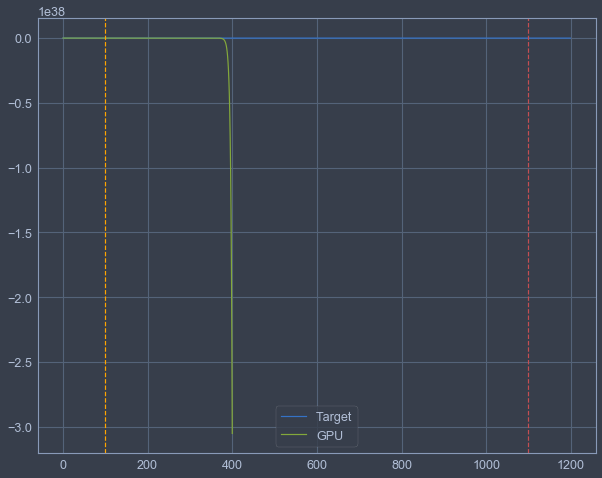

New Best Info a=0.897
 sr=5.917
 amp=0.769
 ri=0.325
 rr=0.797
 nrmse=1000.000
 KL 1000.000


Iter: 44 #### Diagnostic 1000.000   Time 5.090 Best 0.000  KL 1000.000 NRMSE 1000.000
MSE 1000.000   CM 0.250
Iter: 45 #### Diagnostic 1000.000   Time 4.249 Best 0.000  KL 2.008 NRMSE 1000.000
MSE 1000.000   CM 0.117
Iter: 46 #### Diagnostic 1000.000   Time 4.700 Best 0.000  KL 1.178 NRMSE 1000.000
MSE 1000.000   CM 0.249
Iter: 47 #### Diagnostic 1000.000   Time 5.472 Best 0.000  KL 2.160 NRMSE 1000.000
MSE 1000.000   CM 0.193
Iter: 48 #### Diagnostic 1000.000   Time 4.908 Best 0.000  KL 1.978 NRMSE 1000.000
MSE 1000.000   CM 1000.000
Iter: 49 #### Diagnostic 1000.000   Time 5.095 Best 0.000  KL 1000.000 NRMSE 1000.000
MSE 0.289   CM 0.053
Iter: 50 #### Diagnostic 0.289   Time 4.310 Best 0.000  KL 0.446 NRMSE 0.289
MSE 0.259   CM 0.127
Iter: 51 #### Diagnostic 0.259   Time 4.330 Best 0.000  KL 1.540 NRMSE 0.259
MSE 1000.000   CM 0.101
Iter: 52 #### Diagnostic 1000.000   Time 4.654 Best 0.000  

MSE 0.316   CM 0.464
Iter: 122 #### Diagnostic 0.316   Time 6.737 Best 0.000  KL 6.005 NRMSE 0.316
MSE 0.274   CM 0.369
Iter: 123 #### Diagnostic 0.274   Time 7.684 Best 0.000  KL 9.124 NRMSE 0.274
MSE 0.306   CM 0.028
Iter: 124 #### Diagnostic 0.306   Time 5.454 Best 0.000  KL 0.174 NRMSE 0.306
MSE 0.267   CM 0.026
Iter: 125 #### Diagnostic 0.267   Time 6.315 Best 0.000  KL 1000.000 NRMSE 0.267
MSE 0.298   CM 0.591
Iter: 126 #### Diagnostic 0.298   Time 7.119 Best 0.000  KL 12.168 NRMSE 0.298
MSE 0.322   CM 0.241
Iter: 127 #### Diagnostic 0.322   Time 6.715 Best 0.000  KL 4.020 NRMSE 0.322
MSE 3.308   CM 0.592
Iter: 128 #### Diagnostic 3.308   Time 7.613 Best 0.000  KL 7.656 NRMSE 3.308
MSE 0.295   CM 0.407
Iter: 129 #### Diagnostic 0.295   Time 6.092 Best 0.000  KL 10.453 NRMSE 0.295
MSE 0.336   CM 0.253
Iter: 130 #### Diagnostic 0.336   Time 7.783 Best 0.000  KL 2.611 NRMSE 0.336
MSE 0.267   CM 0.391
Iter: 131 #### Diagnostic 0.267   Time 7.592 Best 0.000  KL 8.897 NRMSE 0.267
MSE 0

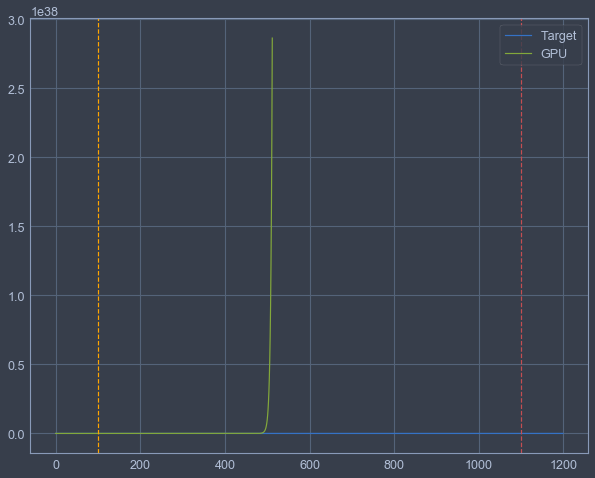

New Best Info a=0.069
 sr=5.318
 amp=0.195
 ri=0.926
 rr=0.527
 nrmse=1000.000
 KL 1.808


Iter: 0 #### Diagnostic 1000.000   Time 10.249 Best 220.578  KL 1.808 NRMSE 1000.000
MSE 1000.000   CM 1000.000
Iter: 1 #### Diagnostic 1000.000   Time 9.178 Best 220.578  KL 1000.000 NRMSE 1000.000
MSE 0.279   CM 0.081
Loss 0.27894512266409616   lc 0.022525541668349223


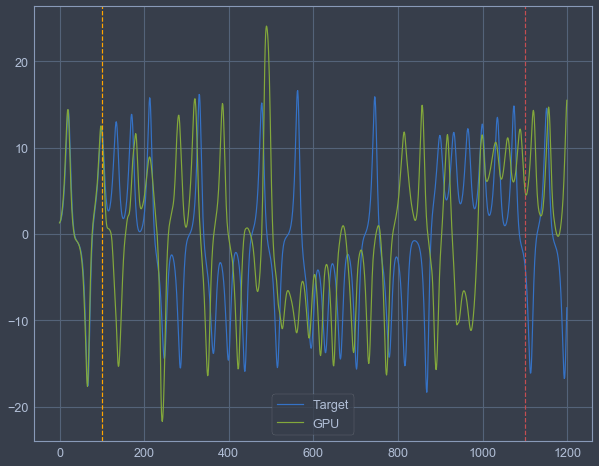

New Best Info a=0.714
 sr=4.144
 amp=0.786
 ri=0.588
 rr=3.684
 nrmse=0.279
 KL 0.486


Iter: 2 #### Diagnostic 0.279   Time 7.807 Best 0.023  KL 0.486 NRMSE 0.279
MSE 0.237   CM 0.796
Iter: 3 #### Diagnostic 0.237   Time 6.554 Best 0.023  KL 24.212 NRMSE 0.237
MSE 1000.000   CM 0.127
Iter: 4 #### Diagnostic 1000.000   Time 10.244 Best 0.023  KL 1.012 NRMSE 1000.000
MSE 0.251   CM 0.447
Iter: 5 #### Diagnostic 0.251   Time 7.797 Best 0.023  KL 5.278 NRMSE 0.251
MSE 1000.000   CM 1000.000
Iter: 6 #### Diagnostic 1000.000   Time 9.103 Best 0.023  KL 1000.000 NRMSE 1000.000
MSE 0.283   CM 0.146
Iter: 7 #### Diagnostic 0.283   Time 7.019 Best 0.023  KL 1.935 NRMSE 0.283
MSE 1000.000   CM 0.107
Iter: 8 #### Diagnostic 1000.000   Time 10.832 Best 0.023  KL 0.432 NRMSE 1000.000
MSE 1.988   CM 0.310
Iter: 9 #### Diagnostic 1.988   Time 6.130 Best 0.023  KL 1.790 NRMSE 1.988
MSE 1763048111674097410364464431104.000   CM 0.096
Iter: 10 #### Diagnostic 1000.000   Time 4.880 Best 0.023  KL 0.526 NR

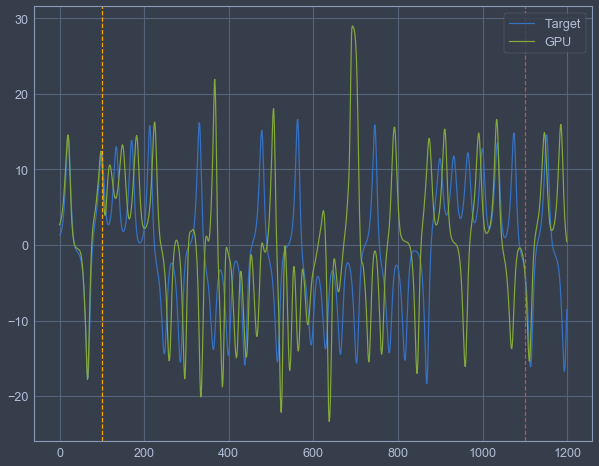

New Best Info a=0.994
 sr=2.562
 amp=0.789
 ri=0.216
 rr=4.756
 nrmse=0.314
 KL 0.256


Iter: 11 #### Diagnostic 0.314   Time 4.577 Best 0.009  KL 0.256 NRMSE 0.314
MSE 0.284   CM 0.058
Iter: 12 #### Diagnostic 0.284   Time 4.097 Best 0.009  KL 0.644 NRMSE 0.284
MSE 1000.000   CM 0.292
Iter: 13 #### Diagnostic 1000.000   Time 5.088 Best 0.009  KL 5.092 NRMSE 1000.000
MSE 0.338   CM 0.221
Iter: 14 #### Diagnostic 0.338   Time 5.041 Best 0.009  KL 1.110 NRMSE 0.338
MSE 1000.000   CM 0.181
Iter: 15 #### Diagnostic 1000.000   Time 5.434 Best 0.009  KL 0.625 NRMSE 1000.000
MSE 1000.000   CM 0.245
Iter: 16 #### Diagnostic 1000.000   Time 5.549 Best 0.009  KL 3.175 NRMSE 1000.000
MSE 7.472   CM 0.246
Iter: 17 #### Diagnostic 7.472   Time 5.116 Best 0.009  KL 1.333 NRMSE 7.472
MSE 1000.000   CM 0.309
Iter: 18 #### Diagnostic 1000.000   Time 5.615 Best 0.009  KL 2.595 NRMSE 1000.000
MSE 0.287   CM 0.222
Iter: 19 #### Diagnostic 0.287   Time 4.827 Best 0.009  KL 3.140 NRMSE 0.287
MSE 0.286   CM 

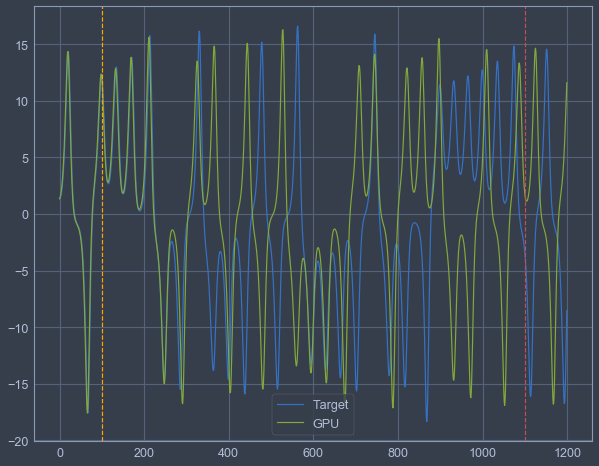

New Best Info a=0.649
 sr=1.271
 amp=0.909
 ri=0.082
 rr=1.510
 nrmse=0.265
 KL 0.227


Iter: 28 #### Diagnostic 0.265   Time 4.879 Best 0.007  KL 0.227 NRMSE 0.265
MSE 0.317   CM 0.544
Iter: 29 #### Diagnostic 0.317   Time 5.160 Best 0.007  KL 9.822 NRMSE 0.317
MSE 157160768727766980093569662976.000   CM 0.191
Iter: 30 #### Diagnostic 1000.000   Time 5.219 Best 0.007  KL 2.367 NRMSE 157160768727766980093569662976.000
MSE 1000.000   CM 0.197
Iter: 31 #### Diagnostic 1000.000   Time 8.294 Best 0.007  KL 1.336 NRMSE 1000.000
MSE 93116239.068   CM 0.225
Iter: 32 #### Diagnostic 1000.000   Time 8.461 Best 0.007  KL 1.266 NRMSE 93116239.068
MSE 1000.000   CM 0.088
Iter: 33 #### Diagnostic 1000.000   Time 7.577 Best 0.007  KL 0.829 NRMSE 1000.000
MSE 0.503   CM 0.982
Iter: 34 #### Diagnostic 0.503   Time 8.353 Best 0.007  KL 16.164 NRMSE 0.503
MSE 1000.000   CM 0.219
Iter: 35 #### Diagnostic 1000.000   Time 8.315 Best 0.007  KL 1.594 NRMSE 1000.000
MSE 1000.000   CM 0.109
Iter: 36 #### Diagn

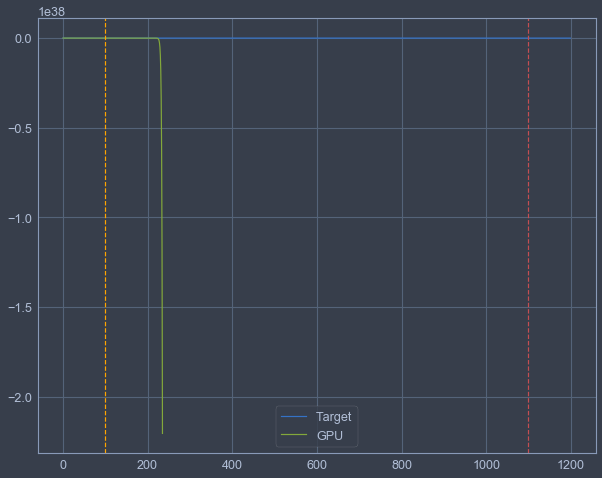

New Best Info a=0.350
 sr=5.066
 amp=0.750
 ri=0.163
 rr=1.267
 nrmse=1000.000
 KL 1000.000


Iter: 86 #### Diagnostic 1000.000   Time 8.737 Best 0.000  KL 1000.000 NRMSE 1000.000
MSE 1000.000   CM 0.207
Iter: 87 #### Diagnostic 1000.000   Time 7.395 Best 0.000  KL 1.230 NRMSE 1000.000
MSE 0.312   CM 0.047
Iter: 88 #### Diagnostic 0.312   Time 7.623 Best 0.000  KL 0.479 NRMSE 0.312
MSE 0.297   CM 0.083
Iter: 89 #### Diagnostic 0.297   Time 7.696 Best 0.000  KL 0.750 NRMSE 0.297
MSE 1000.000   CM 0.060
Iter: 90 #### Diagnostic 1000.000   Time 9.173 Best 0.000  KL 0.105 NRMSE 1000.000
MSE 1000.000   CM 0.224
Iter: 91 #### Diagnostic 1000.000   Time 8.524 Best 0.000  KL 1.839 NRMSE 1000.000
MSE 1000.000   CM 0.289
Iter: 92 #### Diagnostic 1000.000   Time 9.488 Best 0.000  KL 2.766 NRMSE 1000.000
MSE 1000.000   CM 0.184
Iter: 93 #### Diagnostic 1000.000   Time 8.177 Best 0.000  KL 1.484 NRMSE 1000.000
MSE 0.338   CM 0.620
Iter: 94 #### Diagnostic 0.338   Time 8.742 Best 0.000  KL 10.209 NR

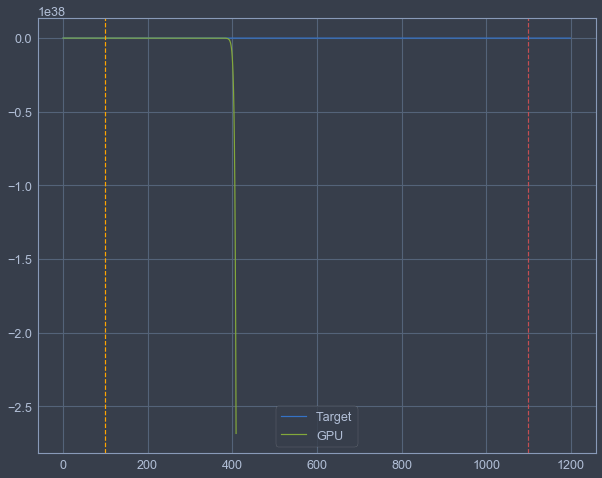

New Best Info a=0.069
 sr=5.318
 amp=0.195
 ri=0.926
 rr=0.527
 nrmse=1000.000
 KL 0.647


Iter: 0 #### Diagnostic 1000.000   Time 4.830 Best 151.650  KL 0.647 NRMSE 1000.000
MSE 1000.000   CM 1000.000
Iter: 1 #### Diagnostic 1000.000   Time 5.304 Best 151.650  KL 1000.000 NRMSE 1000.000
MSE 0.239   CM 0.088
Loss 0.23914439644395033   lc 0.021133333498267293


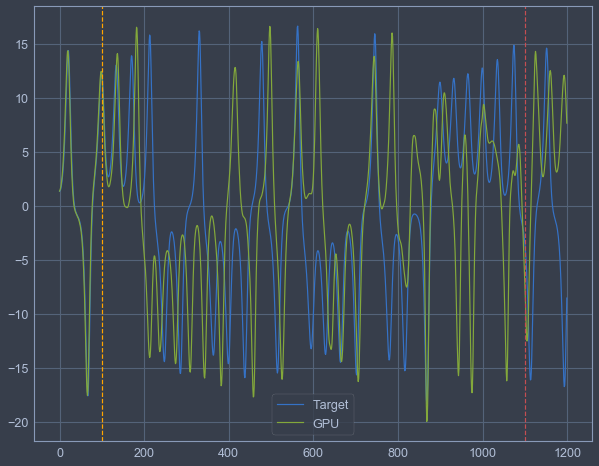

New Best Info a=0.714
 sr=4.144
 amp=0.786
 ri=0.588
 rr=3.684
 nrmse=0.239
 KL 0.779


Iter: 2 #### Diagnostic 0.239   Time 4.307 Best 0.021  KL 0.779 NRMSE 0.239
MSE 0.287   CM 0.060
Loss 0.28741051933820816   lc 0.01727595490168806


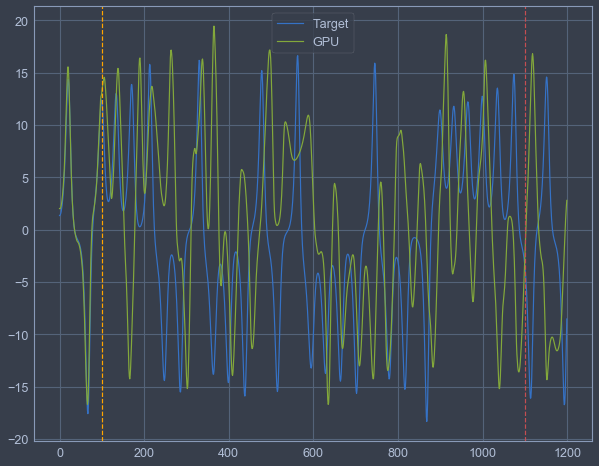

New Best Info a=0.673
 sr=7.761
 amp=0.989
 ri=0.778
 rr=0.127
 nrmse=0.287
 KL 0.104


Iter: 3 #### Diagnostic 0.287   Time 4.648 Best 0.017  KL 0.104 NRMSE 0.287
MSE 1000.000   CM 0.207
Iter: 4 #### Diagnostic 1000.000   Time 5.272 Best 0.017  KL 2.192 NRMSE 1000.000
MSE 0.301   CM 0.170
Iter: 5 #### Diagnostic 0.301   Time 4.014 Best 0.017  KL 1.833 NRMSE 0.301
MSE 1000.000   CM 1000.000
Iter: 6 #### Diagnostic 1000.000   Time 5.490 Best 0.017  KL 1000.000 NRMSE 1000.000
MSE 0.312   CM 0.360
Iter: 7 #### Diagnostic 0.312   Time 4.276 Best 0.017  KL 10.019 NRMSE 0.312
MSE 1000.000   CM 0.245
Iter: 8 #### Diagnostic 1000.000   Time 4.696 Best 0.017  KL 1.910 NRMSE 1000.000
MSE 2.163   CM 0.304
Iter: 9 #### Diagnostic 2.163   Time 4.571 Best 0.017  KL 2.802 NRMSE 2.163
MSE 1000.000   CM 0.315
Iter: 10 #### Diagnostic 1000.000   Time 4.637 Best 0.017  KL 3.304 NRMSE 1000.000
MSE 0.277   CM 0.077
Iter: 11 #### Diagnostic 0.277   Time 4.441 Best 0.017  KL 0.942 NRMSE 0.277
MSE 0.275   CM 

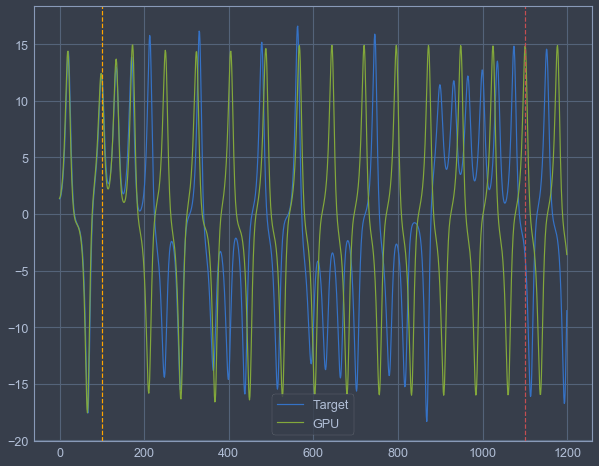

New Best Info a=0.335
 sr=4.015
 amp=0.721
 ri=0.373
 rr=0.794
 nrmse=0.275
 KL 0.654


Iter: 12 #### Diagnostic 0.275   Time 4.407 Best 0.015  KL 0.654 NRMSE 0.275
MSE 8495544595583.825   CM 0.075
Iter: 13 #### Diagnostic 1000.000   Time 4.525 Best 0.015  KL 0.285 NRMSE 8495544595583.825
MSE 0.209   CM 0.263
Iter: 14 #### Diagnostic 0.209   Time 4.608 Best 0.015  KL 4.540 NRMSE 0.209
MSE 1000.000   CM 0.230
Iter: 15 #### Diagnostic 1000.000   Time 5.188 Best 0.015  KL 1.404 NRMSE 1000.000
MSE 0.307   CM 0.817
Iter: 16 #### Diagnostic 0.307   Time 4.014 Best 0.015  KL 15.792 NRMSE 0.307
MSE 1000.000   CM 0.000
Loss 1000   lc 0.0


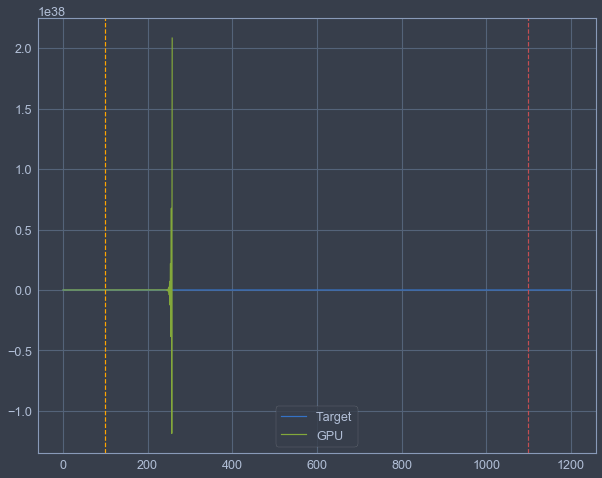

New Best Info a=0.924
 sr=5.924
 amp=0.320
 ri=0.025
 rr=4.308
 nrmse=1000.000
 KL 1000.000


Iter: 17 #### Diagnostic 1000.000   Time 5.676 Best 0.000  KL 1000.000 NRMSE 1000.000
MSE 1000.000   CM 0.105
Iter: 18 #### Diagnostic 1000.000   Time 4.788 Best 0.000  KL 0.935 NRMSE 1000.000
MSE 0.304   CM 0.021
Iter: 19 #### Diagnostic 0.304   Time 4.824 Best 0.000  KL 0.222 NRMSE 0.304
MSE 0.293   CM 0.142
Iter: 20 #### Diagnostic 0.293   Time 4.077 Best 0.000  KL 1.360 NRMSE 0.293
MSE 1000.000   CM 0.116
Iter: 21 #### Diagnostic 1000.000   Time 4.750 Best 0.000  KL 0.830 NRMSE 1000.000
MSE 1000.000   CM 0.294
Iter: 22 #### Diagnostic 1000.000   Time 4.598 Best 0.000  KL 2.814 NRMSE 1000.000
MSE 0.274   CM 0.341
Iter: 23 #### Diagnostic 0.274   Time 3.932 Best 0.000  KL 8.180 NRMSE 0.274
MSE 1000.000   CM 0.070
Iter: 24 #### Diagnostic 1000.000   Time 4.767 Best 0.000  KL 0.399 NRMSE 1000.000
MSE 15.904   CM 0.196
Iter: 25 #### Diagnostic 15.904   Time 4.868 Best 0.000  KL 1.295 NRMSE 15.9

KeyboardInterrupt: 

In [14]:
CALLS = 100
s = torch.torch.from_numpy(signal).cuda().type(dtype)

size = [1000,900,800,700,600,500,400,300,200,100,50]
for N in size:
    min_a, max_a = .001, 1.
    min_sr, max_sr = .001, 8.
    min_g, max_g = .001, 1.
    min_ri, max_ri = .001, 1.
    min_rr, max_rr = .001, 5.
    space = [Real(min_a, max_a, name='a'),
                     Real(min_sr, max_sr, name='sr'),
                     Real(min_g, max_g, name='amp'), 
                     Real(min_ri, max_ri, name='ri'),
                     Real(min_rr, max_rr, name='rr')
                    ]
    for ref in range(5):
        start = time.time()
        alphas = []
        rhos = []
        gammas = []
        inScales = []
        resScales = []
        
        for rn in range(5):
    
    running_error = 1000
    counter = 0 
    print(f'********** Size {N} -- Run {rn} ***********')
    result_gp = gp_minimize(loop,
                            space,
                            n_calls=CALLS,
                            random_state=rand_state[rn],
                            n_jobs=-1, n_initial_points=100)
    print(f'\nBest result = {result_gp.fun}')
    names = ['a','sr','amp','ri','rr']
    for i in range(len(space)):
        print(f'{names[i]} = {result_gp.x[i]}')

    np.save(f'./MM_Lx/Lx_{N}_params_',params)

## End Model

In [4]:
def rank_curve(cplus, tols):
    rank_tols = []
    for i in tols:
        rank_tols.append(rca.rank(cplus, i))
    return np.array(rank_tols)

iteration = [12,63,2,33,11,63,11,11,9,14,26,50,11,26,63,11,40,5,63,16]

size = [1000,950,900,850,800,750,700,650,600,550,500,
        450,400,350,300,250,200,150,100,50]

In [5]:
TOLS = [1/10**(x) for x in range(0,20)]
mm_ranks = []
for ctr,N in zip(iteration,size):
    fn_mats = f'./MultiModelX/Mats/Lx_it{ctr}_{N}_Wnet.npy'
    fn_params = f'./MultiModelX/Params/Lx_it{ctr}_{N}_InstanceParams.npy'
    p = np.load(fn_params, allow_pickle=True)
    a,g = p[0],p[2]

    Wr, Wi = rca.get_mats(fn_mats, K, N)
    xeq = np.zeros((N,1))
    ueq = np.zeros((K,1))
    A = rca.leaky_jacobian(xeq, ueq, a, g, Wi, Wr)
    B = rca.partial_u(xeq, ueq, a, g, Wi, Wr)

    Cplus = np.nan_to_num(rca.reachable_matrix(A, B),0,0,0)
    spec = np.linalg.eigvals(Cplus)
    evs= np.abs(spec)
    Cplus = Cplus/np.max(evs)
    rkc = rank_curve(Cplus,TOLS)
    v = np.argmax(np.gradient(rkc))-1
    ave_rank = (rkc[v]+rkc[v+1])/2
    print(f'Pair: iter {ctr} size {N} argmax {v} {v+1} tol {TOLS[v]} ave {ave_rank}')
    #plt.plot(ave_rank)
    #plt.vlines(v,0,N)
    #plt.show()
    #plt.close
    mm_ranks.append(ave_rank)
    
np.save('./MultiModelX/Lx_MMranks',mm_ranks)

Pair: iter 12 size 1000 argmax 13 14 tol 1e-13 ave 12.0
Pair: iter 63 size 950 argmax 12 13 tol 1e-12 ave 13.0
Pair: iter 2 size 900 argmax 14 15 tol 1e-14 ave 19.5
Pair: iter 33 size 850 argmax 14 15 tol 1e-14 ave 16.5
Pair: iter 11 size 800 argmax 14 15 tol 1e-14 ave 15.5
Pair: iter 63 size 750 argmax 13 14 tol 1e-13 ave 10.0
Pair: iter 11 size 700 argmax 13 14 tol 1e-13 ave 11.5
Pair: iter 11 size 650 argmax 13 14 tol 1e-13 ave 11.0
Pair: iter 9 size 600 argmax 13 14 tol 1e-13 ave 12.0
Pair: iter 14 size 550 argmax 13 14 tol 1e-13 ave 29.0
Pair: iter 26 size 500 argmax 13 14 tol 1e-13 ave 8.0
Pair: iter 50 size 450 argmax 13 14 tol 1e-13 ave 11.5
Pair: iter 11 size 400 argmax 14 15 tol 1e-14 ave 14.5
Pair: iter 26 size 350 argmax 14 15 tol 1e-14 ave 13.5
Pair: iter 63 size 300 argmax 13 14 tol 1e-13 ave 9.5
Pair: iter 11 size 250 argmax 14 15 tol 1e-14 ave 15.5
Pair: iter 40 size 200 argmax 18 19 tol 1e-18 ave 16.5
Pair: iter 5 size 150 argmax 14 15 tol 1e-14 ave 15.5
Pair: iter 63 

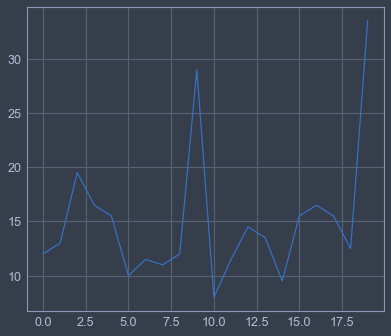

In [6]:
large = np.load('./MultiModelX/Lx_MMranks.npy')
plt.plot(large)
plt.show()

[3.15644485]
[1.3327179]
[3.11181083]
[2.80408775]
[3.01136784]
[2.4717176]
[3.27167682]
[3.39826512]
[2.70650348]
[3.34212909]
[3.29214762]
[3.17140763]
[3.05403614]
[2.7287517]
[3.29908685]
[3.05551742]
[2.66279907]
[2.89663722]
[3.1512512]
[3.01871071]


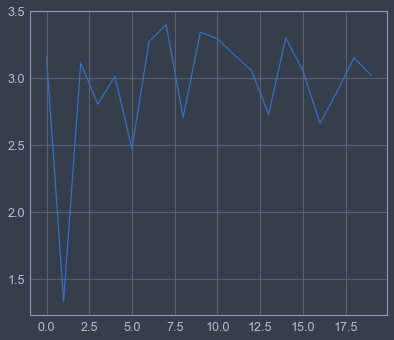

In [7]:
minmax = np.max(signal[:TRAINLENGTH+TEST])-np.min(signal[:TRAINLENGTH+TEST])
err_list = []
for ctr,N in zip(iteration,size):
    pred = np.load(f'./MultiModelX/Preds/Lx_it{ctr}_{N}_Preds.npy', allow_pickle=True)
    rmse = mean_squared_error(signal[TRAINLENGTH:TRAINLENGTH+TEST],pred[TRAINLENGTH:TRAINLENGTH+TEST],
                               squared=False, multioutput='raw_values')
    print(rmse/minmax)
    err_list.append(rmse/minmax)
np.save('./MultiModelX/Lx_mm_errors',np.array(err_list))

plt.plot(err_list)
plt.show()

In [6]:
minmax

38.05303464808486